In [1]:
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
from glob import glob
import numpy as np
import os
from sys import exit as ext
import copy
from bisect import bisect_left
from oco_post_class_ywc import *
from matplotlib import cm
from scipy.interpolate import interpn
from scipy import stats
import geopy.distance
import xarray as xr
import seaborn as sns
%matplotlib inline

"""

from matplotlib import font_manager

font_path = '/System/Library/Fonts/ArialHB.ttc'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
#"""

import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'oco_post_class_ywc'

In [2]:
png       = ['../dat/20150622.png',[-64.5552,-50.1085,-14.2336,2.2510]]
img = png[0]
wesn= png[1]

In [3]:
def grab_cfg(path):
    """
    Read the setting information in the assigned csv file.
    path: relative or absolute path to the setting csv file.
    """
    cfg_file = pd.read_csv(path, header=None, index_col=0)
    result = {'cfg_name':path.split('/')[-1].replace('.csv', '')}
    for ind in cfg_file.index.dropna():
        contents = [str(i) for i in cfg_file.loc[ind].dropna() if str(i)[0] != '#']
        if len(contents) == 1:
            result[ind] = contents[0]
        elif len(contents) > 1:
            result[ind] = contents
    return result

def output_h5_info(cfg, index):
    """
    Check whether the output h5 name is saved in cfg file
    """
    try: 
        cfg_file = grab_cfg(cfg)
    except OSError as err:
        print('{} not exists!'.format(cfg))
        return False
    if index in cfg_file.keys():
        if cfg_file[index][-2:] == 'h5':
            return cfg_file[index]
    else:
        return False
    
def get_slope_1km(OCO_class,fp,z,mode='unperturb'):
    nwl=OCO_class.sls_1km[z,fp,:].shape[0]
    flt=np.where(OCO_class.sls_1km[z,fp,:]>1e-6)
    #flt=np.where(~np.isnan(sls[:]))
    use=len(flt[0])
    if use==nwl:
        w=1./OCO_class.sls_1km[z,fp,:]    
        if mode=='unperturb':
            x=OCO_class.rad_1km_c3d[z,fp,:]/OCO_class.toa[:]*np.pi
        else:
            x=OCO_class.rad_1km_clr[z,fp,:]/OCO_class.toa[:]*np.pi
        res=np.polyfit(x,OCO_class.sl_1km[z,fp,:],1,w=w,cov=True) # now get covariance as well!
        slope,intercept=res[0]
        slopestd=np.sqrt(res[1][0][0])
        interceptstd=np.sqrt(res[1][1][1])
    else:
        slope=np.nan; slopestd=np.nan; intercept=np.nan; interceptstd=np.nan
    return(slope,slopestd,intercept,interceptstd)

def get_slope_25p(OCO_class,fp,z,mode='unperturb'):
    nwl=OCO_class.sls_25p[z,fp,:].shape[0]
    flt=np.where(OCO_class.sls_25p[z,fp,:]>1e-6)
    #flt=np.where(~np.isnan(sls[:]))
    use=len(flt[0])
    if use==nwl:
        w=1./OCO_class.sls_25p[z,fp,:]
        if mode=='unperturb':
            x=OCO_class.rad_25p_c3d[z,fp,:]/OCO_class.toa[:]*np.pi
        else:
            x=OCO_class.rad_25p_clr[z,fp,:]/OCO_class.toa[:]*np.pi   
        res=np.polyfit(x,OCO_class.sl_25p[z,fp,:],1,w=w,cov=True) # now get covariance as well!
        slope,intercept=res[0]
        slopestd=np.sqrt(res[1][0][0])
        interceptstd=np.sqrt(res[1][1][1])
    else:
        slope=np.nan; slopestd=np.nan; intercept=np.nan; interceptstd=np.nan
    return(slope,slopestd,intercept,interceptstd)

def slopes_propagation(OCO_class,mode='unperturb'): # goes through entire line for a given footprint fp
    OCO_class.slope_1km=np.zeros([OCO_class.nz,OCO_class.nf,2])
    OCO_class.inter_1km=np.zeros([OCO_class.nz,OCO_class.nf,2])
    OCO_class.slope_25p=np.zeros([OCO_class.nz,OCO_class.nf,2])
    OCO_class.inter_25p=np.zeros([OCO_class.nz,OCO_class.nf,2])
    for z in range(OCO_class.nz):
        for fp in range(OCO_class.nf):
            if ~ np.isnan(OCO_class.co2[z,fp,]):
                slope,slopestd,inter,interstd=OCO_class.get_slope(fp,z,mode='unperturb')
                OCO_class.slope[z,fp,:]=[slope,slopestd]
                OCO_class.inter[z,fp,:]=[inter,interstd]
                slope,slopestd,inter,interstd=get_slope_1km(OCO_class, fp,z,mode='unperturb')
                OCO_class.slope_1km[z,fp,:]=[slope,slopestd]
                OCO_class.inter_1km[z,fp,:]=[inter,interstd]  
                slope,slopestd,inter,interstd=get_slope_25p(OCO_class, fp,z,mode='unperturb')
                OCO_class.slope_25p[z,fp,:]=[slope,slopestd]
                OCO_class.inter_25p[z,fp,:]=[inter,interstd]  

In [4]:
def near_rad_calc(OCO_class):
    rad_mca_ipa0 = np.zeros((OCO_class.lat.shape[0], OCO_class.lat.shape[1], OCO_class.lam.size), dtype=np.float64)
    rad_mca_ipa  = np.zeros((OCO_class.lat.shape[0], OCO_class.lat.shape[1], OCO_class.lam.size), dtype=np.float64)
    rad_mca_3d   = np.zeros((OCO_class.lat.shape[0], OCO_class.lat.shape[1], OCO_class.lam.size), dtype=np.float64)

    rad_mca_ipa0_std = np.zeros((OCO_class.lat.shape[0], OCO_class.lat.shape[1], OCO_class.lam.size), dtype=np.float64)
    rad_mca_ipa_std  = np.zeros((OCO_class.lat.shape[0], OCO_class.lat.shape[1], OCO_class.lam.size), dtype=np.float64)
    rad_mca_3d_std   = np.zeros((OCO_class.lat.shape[0], OCO_class.lat.shape[1], OCO_class.lam.size), dtype=np.float64)

    rad_mca_ipa0[...] = np.nan
    rad_mca_ipa[...] = np.nan
    rad_mca_3d[...] = np.nan

    rad_mca_ipa0_std[...] = np.nan
    rad_mca_ipa_std[...] = np.nan
    rad_mca_3d_std[...] = np.nan

    rad_mca_ipa0_25 = rad_mca_ipa0.copy()
    rad_mca_ipa_25 = rad_mca_ipa0.copy()
    rad_mca_3d_25 = rad_mca_ipa0.copy()

    rad_mca_ipa0_std_25 = rad_mca_ipa0.copy()
    rad_mca_ipa_std_25 = rad_mca_ipa0.copy()
    rad_mca_3d_std_25 = rad_mca_ipa0.copy()
    count = 0
    for i in range(OCO_class.lat.shape[0]):
        for j in range(OCO_class.lat.shape[1]):
            if ~ np.isnan(OCO_class.co2[i, j]):
                lon0 = OCO_class.lon[i, j]
                lat0 = OCO_class.lat[i, j]      
                index_lon = np.argmin(np.abs(OCO_class.lon2d[:, 0]-lon0))
                index_lat = np.argmin(np.abs(OCO_class.lat2d[0, :]-lat0))

                center = (lon0, lat0)
                tmp_clr, tmp_c1d, tmp_c3d = [], [], []
                tmp_clrs, tmp_c1ds, tmp_c3ds = [], [], []
                test_range = (np.arange(-10, 10+1))
                for x in test_range:
                    for y in test_range:
                        try:
                            interest_loc = (OCO_class.lon2d[index_lon+x, 0], OCO_class.lat2d[0, index_lat+y])
                            if geopy.distance.distance(center, interest_loc).km <= 1.0:

                                tmp_clr.append(OCO_class.rad_clr[index_lon+x, index_lat+y])
                                tmp_c1d.append(OCO_class.rad_c1d[index_lon+x, index_lat+y])
                                tmp_c3d.append(OCO_class.rad_c3d[index_lon+x, index_lat+y])
                                tmp_clrs.append(OCO_class.rad_clrs[index_lon+x, index_lat+y])
                                tmp_c1ds.append(OCO_class.rad_c1ds[index_lon+x, index_lat+y])
                                tmp_c3ds.append(OCO_class.rad_c3ds[index_lon+x, index_lat+y])
                                count += 1
                        except:
                            None
                
                rad_mca_ipa0[i, j, :] = np.nanmean(np.array(tmp_clr), axis=0)
                rad_mca_ipa[i, j, :]  = np.nanmean(np.array(tmp_c1d), axis=0)
                rad_mca_3d[i, j, :]   = np.nanmean(np.array(tmp_c3d), axis=0)

                rad_mca_ipa0_std[i, j, :] = (np.nanstd(np.array(tmp_clr), axis=0))
                rad_mca_ipa_std[i, j, :]  = (np.nanstd(np.array(tmp_c1d), axis=0))
                rad_mca_3d_std[i, j, :]   = (np.nanstd(np.array(tmp_c3d), axis=0))


                rad_mca_ipa0_25[i, j, :] = np.nanmean(OCO_class.rad_clr[index_lon-2:index_lon+3, 
                                                                 index_lat-2:index_lat+3], 
                                                      axis=(0, 1))
                rad_mca_ipa_25[i, j, :]  = np.nanmean(OCO_class.rad_c1d[index_lon-2:index_lon+3, 
                                                                 index_lat-2:index_lat+3], 
                                                      axis=(0, 1))
                rad_mca_3d_25[i, j, :]   = np.nanmean(OCO_class.rad_c3d[index_lon-2:index_lon+3, 
                                                                 index_lat-2:index_lat+3], 
                                                      axis=(0, 1))
                
                rad_mca_ipa0_std_25[i, j, :] = (np.nanstd(OCO_class.rad_clr[index_lon-2:index_lon+3,
                                                                      index_lat-2:index_lat+3],
                                                          axis=(0, 1)))
                rad_mca_ipa_std_25[i, j, :]  = (np.nanstd(OCO_class.rad_c1d[index_lon-2:index_lon+3,
                                                                      index_lat-2:index_lat+3],
                                                          axis=(0, 1)))
                rad_mca_3d_std_25[i, j, :]   = (np.nanstd(OCO_class.rad_c3d[index_lon-2:index_lon+3,
                                                                      index_lat-2:index_lat+3],
                                                          axis=(0, 1)))
    print(count)
    OCO_class.rad_1km_clr = rad_mca_ipa0
    OCO_class.rad_1km_c1d = rad_mca_ipa
    OCO_class.rad_1km_c3d = rad_mca_3d

    OCO_class.rad_1km_clrs = rad_mca_ipa0_std
    OCO_class.rad_1km_c1ds = rad_mca_ipa_std
    OCO_class.rad_1km_c3ds = rad_mca_3d_std

    OCO_class.rad_25p_clr = rad_mca_ipa0_25
    OCO_class.rad_25p_c1d = rad_mca_ipa_25
    OCO_class.rad_25p_c3d = rad_mca_3d_25

    OCO_class.rad_25p_clrs = rad_mca_ipa0_std_25
    OCO_class.rad_25p_c1ds = rad_mca_ipa_std_25
    OCO_class.rad_25p_c3ds = rad_mca_3d_std_25
    
    OCO_class.sl_1km  = (OCO_class.rad_1km_c3d-OCO_class.rad_1km_clr) / OCO_class.rad_1km_clr        # S_lamda
    OCO_class.sls_1km = (OCO_class.rad_1km_c3ds/OCO_class.rad_1km_clr + OCO_class.rad_1km_clrs/OCO_class.rad_1km_clr)
    OCO_class.sl_25p  = (OCO_class.rad_25p_c3d-OCO_class.rad_25p_clr) / OCO_class.rad_25p_clr        # S_lamda
    OCO_class.sls_25p = (OCO_class.rad_25p_c3ds/OCO_class.rad_25p_clr + OCO_class.rad_25p_clrs/OCO_class.rad_25p_clr)

In [138]:
sb = np.load('../simulation/subdomain_list.npy')
cfg_dir = '../simulation/cfg'
cfg_basename = '20150622_{:.0f}_{:.0f}.csv'
id_list = []
boundary_list = []
for i in [0, 1, 2, 3, 5, 7]:# , 2, 3, 5, 6, 7, 8, 13, 14, 15, 17, 19, 20, 21, 22]:
    s, n = sb[i, 2:]
    cfg = cfg_basename.format(s*100, n*100)
    print(cfg)
    cfg_info = grab_cfg(f'{cfg_dir}/{cfg}')
    if 'o2' in cfg_info.keys():
        id_list.append(output_h5_info(f'{cfg_dir}/{cfg}', 'o2')[-12:-3])
        boundary_list.append([[float(i) for i in cfg_info['subdomain']], 'r'])
    else:
        boundary_list.append([[float(i) for i in cfg_info['subdomain']], 'orange'])

id_list = sorted(id_list, reverse=True)

20150622_163_225.csv
20150622_107_168.csv
20150622_50_112.csv
20150622_-7_55.csv
20150622_-120_-58.csv
20150622_-233_-172.csv


In [139]:
"""
for i in range(len(id_list)):
    id_num = id_list[i]
    #filename = '../simulation/output_1e8/data_all_20150622_{}_{}.h5'
    filename = '../simulation/photon_1e8/data_all_20150622_{}_{}.h5'
    o2a_file  = filename.format('o2a', id_num)
    wco2_file = filename.format('wco2', id_num)
    sco2_file = filename.format('sco2', id_num)
    for (var, varfile) in [('o1', o2a_file), ('o2', wco2_file), ('o3', sco2_file)]:
        vars()['{}_temp{}'.format(var, i)] = OCOSIM(varfile)
        for j in range(8):
            vars()['{}_temp{}'.format(var, i)].slopes(j)
        near_rad_calc(vars()['{}_temp{}'.format(var, i)])
        slopes_propagation(vars()['{}_temp{}'.format(var, i)])
for var in ['o1', 'o2', 'o3']:
    vars()[var] = copy.copy(vars()['{}_temp0'.format(var)])
    for i in range(1, len(id_list)):
        vars()[var].combine(vars()['{}_temp{}'.format(var, i)])
"""

2406
2406
2406
3540
3540
3540
1623
1623
1623
1759
1759
1759
2393
2393


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '../simulation/photon_1e8/data_all_20150622_sco2_2751_2783.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [140]:
for i in range(len(id_list)):
    id_num = id_list[i]
    #filename = '../simulation/output_1e8/data_all_20150622_{}_{}.h5'
    filename = '../simulation/photon_1e8/data_all_20150622_{}_{}.h5'
    o2a_file  = filename.format('o2a', id_num)
    wco2_file = filename.format('wco2', id_num)
    sco2_file = filename.format('sco2', id_num)
    for (var, varfile) in [('o1', o2a_file), ('o2', wco2_file)]:
        vars()['{}_temp{}'.format(var, i)] = OCOSIM(varfile)
        for j in range(8):
            vars()['{}_temp{}'.format(var, i)].slopes(j)
        near_rad_calc(vars()['{}_temp{}'.format(var, i)])
        slopes_propagation(vars()['{}_temp{}'.format(var, i)])
for var in ['o1', 'o2']:
    vars()[var] = copy.copy(vars()['{}_temp0'.format(var)])
    for i in range(1, len(id_list)):
        vars()[var].combine(vars()['{}_temp{}'.format(var, i)])

2406
2406
3540
3540
1623
1623
1759
1759
2393
2393
6720
6720


In [11]:
def save_subdomain_info(cfg, subdomain):
    """
    Save the subdomain info into cfg file
    """
    cfg_file = pd.read_csv(cfg, header=None, index_col=0)
    for j in range(4):
        cfg_file.loc['subdomain', j+1] = subdomain[j]
    cfg_file.to_csv(cfg, header=False)
    return None

In [237]:
# export slope to new cfg file
sb = np.load('../simulation/subdomain_list.npy')
cfg_dir = '../simulation/cfg'
cfg_ret_dir = '../simulation/cfg_retrieve'
cfg_basename = '20150622_{:.0f}_{:.0f}.csv'
id_list = []
boundary_list = []
for i in [1]:
    s, n = sb[i, 2:]
    cfg = cfg_basename.format(s*100, n*100)
    print(cfg)
    #if not os.path.exists(f'{cfg_ret_dir}/{cfg}'):
    os.system(f'cp {cfg_ret_dir}/20150622_ret_template.csv {cfg_ret_dir}/{cfg}')
    save_subdomain_info(f'{cfg_ret_dir}/{cfg}', sb[i])
    cfg_file = pd.read_csv(f'{cfg_ret_dir}/{cfg}', header=None, index_col=0)
    #"""
    id_num = output_h5_info(f'{cfg_dir}/{cfg}', 'o2')[-12:-3]
    #filename = '../simulation/output_1e8/data_all_20150622_{}_{}.h5'
    filename = '../simulation/photon_1e8/data_all_20150622_{}_{}.h5'
    o2a_file  = filename.format('o2a', id_num)
    wco2_file = filename.format('wco2', id_num)
    sco2_file = filename.format('sco2', id_num)
    for (var, varfile) in [('o1', o2a_file), ('o2', wco2_file), ('o3', sco2_file)]:
        vars()['{}'.format(var)] = OCOSIM(varfile)
        for j in range(8):
            vars()['{}'.format(var, i)].slopes(j)
        near_rad_calc(vars()['{}'.format(var, i)])
        slopes_propagation(vars()['{}'.format(var)])
    #"""
    oco_data = pd.DataFrame(np.array([o1.lon.flatten(), 
                                  o1.lat.flatten(), 
                                  o1.co2.flatten()*1e6, # to ppm
                                  o1.psur.flatten()/1000, # to kPa
                                  o1.inter_1km[:, :, 0].flatten(), 
                                  o1.slope_1km[:, :, 0].flatten(), 
                                  o2.inter_1km[:, :, 0].flatten(), 
                                  o2.slope_1km[:, :, 0].flatten(),
                                  o3.inter_1km[:, :, 0].flatten(), 
                                  o3.slope_1km[:, :, 0].flatten()]).T,
                         index = pd.Series(o1.snd.flatten()).astype(str).apply(lambda x:'SND'+x),
                         columns=range(1, 11))
    oco_data = oco_data[~np.isnan(oco_data.iloc[:, 2])]
    output = pd.concat([cfg_file, oco_data])
    output.to_csv(f'{cfg_ret_dir}/{cfg}', header=False)


20150622_107_168.csv
3540
3540
3540


In [238]:
test = pd.DataFrame(np.array([o1.lon.flatten(), 
                                  o1.lat.flatten(), 
                                  o1.co2.flatten()*1e6, # to ppm
                                  o1.psur.flatten()/1000, # to kPa
                                  o1.inter_1km[:, :, 0].flatten(), 
                                  o1.slope_1km[:, :, 0].flatten(), 
                                  o2.inter_1km[:, :, 0].flatten(), 
                                  o2.slope_1km[:, :, 0].flatten(),
                                  o3.inter_1km[:, :, 0].flatten(), 
                                  o3.slope_1km[:, :, 0].flatten()]).T,
                         index = pd.Series(o1.snd.flatten()).astype(str),
                         columns=range(1, 11))
test = test[~np.isnan(test.iloc[:, 2])]
test.index[6:]

Index(['2015062217260804', '2015062217260805', '2015062217260806',
       '2015062217260831', '2015062217260837', '2015062217260838',
       '2015062217260937', '2015062217260973', '2015062217260974',
       '2015062217260975', '2015062217260976', '2015062217260977',
       '2015062217260978', '2015062217261008', '2015062217261137',
       '2015062217261171', '2015062217261172', '2015062217261177',
       '2015062217261178', '2015062217261205', '2015062217261206',
       '2015062217261207', '2015062217261208', '2015062217261237',
       '2015062217261238', '2015062217261302', '2015062217261471',
       '2015062217261472', '2015062217261501', '2015062217261502',
       '2015062217261503', '2015062217261504', '2015062217261534',
       '2015062217261535', '2015062217261536', '2015062217261577'],
      dtype='object')

In [130]:
oco_data = pd.DataFrame(np.array([o1.lon.flatten(), 
                                  o1.lat.flatten(), 
                                  o1.co2.flatten()*1e6, # to ppm
                                  o1.psur.flatten()/1000, # to kPa
                                  o1.inter_1km[:, :, 0].flatten(), 
                                  o1.slope_1km[:, :, 0].flatten(), 
                                  o2.inter_1km[:, :, 0].flatten(), 
                                  o2.slope_1km[:, :, 0].flatten(),
                                  o3.inter_1km[:, :, 0].flatten(), 
                                  o3.slope_1km[:, :, 0].flatten()]).T,
                         index = pd.Series(o1.snd.flatten(), name='snd'),
                         columns=range(1, 11))
"""                         
                         columns=['lon', 'lat', 'XCO2', 'Psfc', 
                                  'o2_intercept', 'o2_slope',
                                  'wco2_intercept', 'wcoo2_slope',
                                  'sco2_intercept', 'sco2_slope',])
"""

"                         \n                         columns=['lon', 'lat', 'XCO2', 'Psfc', \n                                  'o2_intercept', 'o2_slope',\n                                  'wco2_intercept', 'wcoo2_slope',\n                                  'sco2_intercept', 'sco2_slope',])\n"

In [133]:
new_oco = new_oco[~np.isnan(new_oco.iloc[:, 2])]
new_oco.index#.apply(lambda x:'SND'+x)

Index(['2015062217261905', '2015062217261933', '2015062217261934',
       '2015062217261935', '2015062217261936', '2015062217261937',
       '2015062217261973', '2015062217261974', '2015062217262004',
       '2015062217262171', '2015062217262172', '2015062217262201',
       '2015062217262202', '2015062217262203', '2015062217262232',
       '2015062217262233', '2015062217262274', '2015062217262275',
       '2015062217262277', '2015062217262337', '2015062217262338',
       '2015062217262533', '2015062217262575', '2015062217262576',
       '2015062217262608', '2015062217262637', '2015062217262675',
       '2015062217262676', '2015062217262677'],
      dtype='object', name='snd')

In [92]:
#new_oco = oco_data[~np.isnan(oco_data.iloc[:, 2])]
new_oco

,1,2,3,4,5,6,7,8,9,10
snd,,,,,,,,,,
2015062217261905,-57.733040,1.783447,397.482605,98.768692,0.297682,0.061594,0.458802,-0.496447,0.458802,-0.496447
2015062217261933,-57.720448,1.816324,398.998444,98.761375,0.166535,0.710332,0.204746,-0.074970,0.204746,-0.074970
2015062217261934,-57.728889,1.809901,399.655548,98.714424,0.073614,0.574100,0.112896,-0.024629,0.112896,-0.024629
2015062217261935,-57.737328,1.803599,398.574432,98.674538,0.081412,0.202280,0.108888,-0.290224,0.108888,-0.290224
2015062217261936,-57.745842,1.797339,397.214355,98.367989,0.067204,0.452328,0.100971,-0.053796,0.100971,-0.053796
2015062217261937,-57.754402,1.791135,396.247040,98.479568,0.040568,0.524680,0.072900,0.066243,0.072900,0.066243
2015062217261973,-57.724739,1.836482,397.297546,98.655479,0.192537,-0.373237,0.314984,-0.758683,0.314984,-0.758683
2015062217261974,-57.733181,1.830055,395.483002,98.751907,0.148235,0.012563,0.246141,-0.356037,0.246141,-0.356037
2015062217262004,-57.737473,1.850210,395.480560,99.293198,0.283894,0.192158,0.584896,-0.751405,0.584896,-0.751405


In [101]:
np.array(new_oco.iloc[:, 5])

array([ 0.06159379,  0.71033153,  0.57410011,  0.20228004,  0.45232752,
        0.52467967, -0.37323724,  0.01256318,  0.19215832,  0.39408584,
        0.3212108 ,  0.43212469,  0.31966427,  0.41878541,  0.10489606,
        0.4571283 ,  0.56544187,  0.40610454,  0.34146522,  0.27297633,
        0.45408093,  0.31795188,  0.45436081,  0.0020084 ,  0.2288848 ,
       -0.04279186,  1.65212964,  1.370581  ,  0.97030574])

In [69]:

df = cfg_file.copy()
df2 = pd.DataFrame([123,])
#df = cfg_file.append(df2, ignore_index=True)
df.loc[len(df)] = [1, 2, 3, 4]+[np.nan]*6
df = df.rename(index={len(df)-1: 'ssss'})
#df.loc[123, 1] = 456
df3 = pd.concat([cfg_file, new_oco])

In [70]:
df3

,1,2,3,4,5,6,7,8,9,10
descriptor,Manaus case,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,20150622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
juld,173,NaN,NaN,NaN,NaN,NaN,# Julian Day,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2015062217261504,-57.673927,1.547713,390.676178,98.669357,0.016727,0.988495,0.068205,0.066148,0.068205,0.066148
2015062217261534,-57.678123,1.567896,397.802063,98.892281,0.084186,-0.071747,0.070925,-0.275614,0.070925,-0.275614
2015062217261535,-57.686584,1.561631,398.814667,98.722786,0.055778,0.657117,0.058969,0.037776,0.058969,0.037776
2015062217261536,-57.695122,1.555406,396.797028,98.805664,0.087366,0.836262,0.104555,0.029689,0.104555,0.029689


In [182]:
h1_unpert = h5py.File('full-perturb_20150622_163_225.h5', "r")
h2_unpert = h5py.File('full-perturb_20150622_107_168.h5', "r")
#h4_unpert = h5py.File('full-perturb_20150622_-1083_-1022.h5', "r")
h5_unpert = h5py.File('full-perturb_20150622_50_112.h5', "r")
h6_unpert = h5py.File('full-perturb_20150622_-7_55.h5', "r")
h7_unpert = h5py.File('full-perturb_20150622_-120_-58.h5', "r")
h8_unpert = h5py.File('full-perturb_20150622_-233_-172.h5', "r")

h1_o2a = h5py.File('full-perturb_20150622_163_225_o2a.h5', "r")
h2_o2a = h5py.File('full-perturb_20150622_163_225_o2a_2.h5', "r")
h3_o2a = h5py.File('full-perturb_20150622_107_168_o2a.h5', "r")
h4_o2a = h5py.File('full-perturb_20150622_-1083_-1022_o2a.h5', "r")
h5_o2a = h5py.File('full-perturb_20150622_50_112_o2a.h5', "r")
h6_o2a = h5py.File('full-perturb_20150622_-7_55_o2a.h5', "r")
h7_o2a = h5py.File('full-perturb_20150622_-120_-58_o2a.h5', "r")
h8_o2a = h5py.File('full-perturb_20150622_-233_-172_o2a.h5', "r")

h1_wco2 = h5py.File('full-perturb_20150622_163_225_wco2.h5', "r")
h2_wco2 = h5py.File('full-perturb_20150622_163_225_wco2_2.h5', "r")
h3_wco2 = h5py.File('full-perturb_20150622_107_168_wco2.h5', "r")
h4_wco2 = h5py.File('full-perturb_20150622_-1083_-1022_wco2.h5', "r")
h5_wco2 = h5py.File('full-perturb_20150622_50_112_wco2.h5', "r")
h6_wco2 = h5py.File('full-perturb_20150622_-7_55_wco2.h5', "r")
h7_wco2 = h5py.File('full-perturb_20150622_-120_-58_wco2.h5', "r")
h8_wco2 = h5py.File('full-perturb_20150622_-233_-172_wco2.h5', "r")

h1_o2a_wco2 = h5py.File('full-perturb_20150622_163_225_o2a_wco2.h5', "r")
h2_o2a_wco2 = h5py.File('full-perturb_20150622_163_225_o2a_wco2_2.h5', "r")
h3_o2a_wco2 = h5py.File('full-perturb_20150622_107_168_o2a_wco2.h5', "r")
h4_o2a_wco2 = h5py.File('full-perturb_20150622_-1083_-1022_o2a_wco2.h5', "r")
h5_o2a_wco2 = h5py.File('full-perturb_20150622_50_112_o2a_wco2.h5', "r")
h6_o2a_wco2 = h5py.File('full-perturb_20150622_-7_55_o2a_wco2.h5', "r")
h7_o2a_wco2 = h5py.File('full-perturb_20150622_-120_-58_o2a_wco2.h5', "r")
h8_o2a_wco2 = h5py.File('full-perturb_20150622_-233_-172_o2a_wco2.h5', "r")

h1_o2a.keys()

<KeysViewHDF5 ['aod', 'cpu_minutes', 'lat', 'lon', 'psur_MT_file', 'psur_retrieved', 'rfl1', 'rfl2', 'rfl3', 'snd', 'xco2_L2_file', 'xco2_retrieved', 'xco2_weighted_column']>

In [309]:
h5_snd = h1_o2a['snd'][...]
h5_lon = h1_o2a['lon'][...]
h5_lat = h1_o2a['lat'][...]

h5_xco2_retrieved_unpert = h1_unpert['xco2_retrieved'][...]

h5_xco2_L2_file_o2a = h1_o2a['xco2_L2_file'][...]
h5_xco2_retrieved_o2a = h1_o2a['xco2_retrieved'][...]

h5_xco2_L2_file_wco2 = h1_wco2['xco2_L2_file'][...]
h5_xco2_retrieved_wco2 = h1_wco2['xco2_retrieved'][...]

h5_xco2_L2_file_o2a_wco2 = h1_o2a_wco2['xco2_L2_file'][...]
h5_xco2_retrieved_o2a_wco2 = h1_o2a_wco2['xco2_retrieved'][...]


h5_xco2_retrieved_unpert = np.append(h5_xco2_retrieved_unpert, h2_unpert['xco2_retrieved'][6:])

for h in [h5_unpert, h6_unpert, h7_unpert, h8_unpert]:#, h3, h4]:
    h5_xco2_retrieved_unpert = np.append(h5_xco2_retrieved_unpert, h['xco2_retrieved'])

for h in [h2_o2a, h3_o2a, h5_o2a, h6_o2a, h7_o2a, h8_o2a]:#, h3, h4]:
    h5_snd = np.append(h5_snd, h['snd'][...])
    h5_lon = np.append(h5_lon, h['lon'][...])
    h5_lat = np.append(h5_lat, h['lat'][...])
    
    h5_xco2_L2_file_o2a = np.append(h5_xco2_L2_file_o2a, h['xco2_L2_file'][...])
    h5_xco2_retrieved_o2a = np.append(h5_xco2_retrieved_o2a, h['xco2_retrieved'][...])
    
    
for h in [h2_wco2, h3_wco2, h5_wco2, h6_wco2, h7_wco2, h8_wco2]:#, h3, h4]:    
    h5_xco2_L2_file_wco2 = np.append(h5_xco2_L2_file_wco2, h['xco2_L2_file'][...])
    h5_xco2_retrieved_wco2 = np.append(h5_xco2_retrieved_wco2, h['xco2_retrieved'][...])
    
for h in [h2_o2a_wco2, h3_o2a_wco2, h5_o2a_wco2, h6_o2a_wco2, h7_o2a_wco2, h8_o2a_wco2]:#, h3, h4]:    
    h5_xco2_L2_file_o2a_wco2 = np.append(h5_xco2_L2_file_o2a_wco2, h['xco2_L2_file'][...])
    h5_xco2_retrieved_o2a_wco2 = np.append(h5_xco2_retrieved_o2a_wco2, h['xco2_retrieved'][...])


"""
h4_end = 20

h5_xco2_retrieved_unpert = np.append(h5_xco2_retrieved_unpert, h4_unpert['xco2_retrieved'][:h4_end])

h5_snd = np.append(h5_snd, h4_o2a['snd'][:h4_end])
h5_lon = np.append(h5_lon, h4_o2a['lon'][:h4_end])
h5_lat = np.append(h5_lat, h4_o2a['lat'][:h4_end])

h5_xco2_L2_file_o2a = np.append(h5_xco2_L2_file_o2a, h4_o2a['xco2_L2_file'][:h4_end])
h5_xco2_retrieved_o2a = np.append(h5_xco2_retrieved_o2a, h4_o2a['xco2_retrieved'][:h4_end])

h5_xco2_L2_file_wco2 = np.append(h5_xco2_L2_file_wco2, h4_wco2['xco2_L2_file'][:h4_end])
h5_xco2_retrieved_wco2 = np.append(h5_xco2_retrieved_wco2, h4_wco2['xco2_retrieved'][:h4_end])
h5_xco2_L2_file_o2a_wco2 = np.append(h5_xco2_L2_file_o2a_wco2, h4_o2a_wco2['xco2_L2_file'][:h4_end])
h5_xco2_retrieved_o2a_wco2 = np.append(h5_xco2_retrieved_o2a_wco2, h4_o2a_wco2['xco2_retrieved'][:h4_end])
#"""
    
    
h5_xco2_retrieved_unpert[h5_xco2_retrieved_unpert<100] = np.nan
h5_xco2_retrieved_o2a[h5_xco2_retrieved_o2a<100] = np.nan
h5_xco2_retrieved_wco2[h5_xco2_retrieved_wco2<100] = np.nan
h5_xco2_retrieved_o2a_wco2[h5_xco2_retrieved_o2a_wco2<100] = np.nan

In [184]:
len(h5_xco2_retrieved_unpert)

217

In [155]:
len(h5_xco2_retrieved_o2a)

135

In [88]:
h5_xco2_L2_file_o2a == h5_xco2_L2_file_wco2

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [198]:
litefile = '../dat/oco2_LtCO2_150622_B10206Ar_200730184707s.nc4'
lite = xr.open_dataset(litefile)
cloudfile = '../steve/oco2_LtCO2_150622_B9003r_180928052221s_3Dmetrics.nc4'
cloud = xr.open_dataset(cloudfile)


lon_w, lon_e = wesn[0], wesn[1]
lat_s, lat_n = np.min(h5_lat)-0.05, np.max(h5_lat)+0.05
lon_range = np.logical_and(lite.longitude >= lon_w, lite.longitude <= lon_e)
lat_range = np.logical_and(lite.latitude >= lat_s, lite.latitude <= lat_n)

select = np.where(np.logical_and(lon_range, lat_range))

lite_snd_list = np.array(lite.sounding_id[select], dtype=np.int)

In [146]:
lat_s, lat_n

(-1.054019856, 2.2966742989999998)

In [226]:


qf_array = np.zeros((o1.snd.shape[0], o1.snd.shape[1], 3))
cld_array = np.zeros((o1.snd.shape[0], o1.snd.shape[1], 4))
qf_lon, qf_lat = np.zeros((o1.snd.shape[0], o1.snd.shape[1])), np.zeros((o1.snd.shape[0], o1.snd.shape[1]))
# qf, qf_bitflag, qf_simpleflag\
for i in range(o1.snd.shape[0]):
    for j in range(o1.snd.shape[1]):
        snd = o1.snd[i, j]
        #print('-'*15)
        #print(snd)
        if snd in lite_snd_list:
            index = np.where(lite_snd_list == snd)[0][0]
            xco2_quality_flag = np.float(lite.xco2_quality_flag[select][index])
            xco2_qf_bitflag = np.float(lite.xco2_qf_bitflag[select][index])
            xco2_qf_simple_bitflag = np.float(lite.xco2_qf_simple_bitflag[select][index])
            qf_array[i, j, :] = (xco2_quality_flag, xco2_qf_bitflag, xco2_qf_simple_bitflag)
            qf_lat[i, j] = np.float(lite.latitude[select][index])
            qf_lon[i, j] = np.float(lite.longitude[select][index])
        else:
            qf_array[i, j, :] = (np.nan,)*3
            qf_lat[i, j] = np.nan
            qf_lon[i, j] = np.nan
        if snd in cloud.sounding_id:
            index = np.where(cloud.sounding_id == snd)[0][0]
            cld_dist = np.float(cloud.cld_dist[index])
            h3d = np.float(cloud.h3d[index])
            cs_noise_ratio = np.float(cloud.cs_noise_ratio[index])
            hc = np.float(cloud.hc[index])
            cld_array[i, j, :] = (cld_dist, h3d, cs_noise_ratio, hc)
        else:
            cld_array[i, j, :] = (np.nan,)*4

In [227]:
o1.slope_1km[np.where(o1.snd==2015062217261974)][0][0]

0.012563183629096853

In [269]:
qf_list, cld_list = [], []
o1_s, o2_s, o3_s = [], [], []
lon_list, lat_list, xco2 = [], [], []
for snd in h5_snd:
    qf_list.append(qf_array[np.where(o1.snd==snd)][0][0])
    cld_list.append(cld_array[np.where(o1.snd==snd)][0][0])
    #print(qf_array[np.where(o1.snd==snd)][0][0])
    o1_s.append(o1.slope_1km[np.where(o1.snd==snd)][0][0])
    o2_s.append(o2.slope_1km[np.where(o2.snd==snd)][0][0])
    xco2.append(o1.co2[np.where(o1.snd==snd)][0])
    lon_list.append(o1.lon[np.where(o1.snd==snd)][0])
    lat_list.append(o1.lat[np.where(o1.snd==snd)][0])
    #o3_s.append(o3.slope_1km[np.where(o3.snd==snd)][0][0])
qf_list = np.array(qf_list)
cld_list = np.array(cld_list)
o1_s = np.array(o1_s)
o2_s = np.array(o2_s)
xco2 = np.array(xco2)
del_XCO2_o2a = h5_xco2_retrieved_o2a-h5_xco2_retrieved_unpert
del_XCO2_wco2 = h5_xco2_retrieved_wco2-h5_xco2_retrieved_unpert
del_XCO2_o2a_wco2 = h5_xco2_retrieved_o2a_wco2-h5_xco2_retrieved_unpert
"""
del_XCO2_o2a = h5_xco2_retrieved_o2a-h5_xco2_L2_file_o2a
del_XCO2_wco2 = h5_xco2_retrieved_wco2-h5_xco2_L2_file_wco2
del_XCO2_o2a_wco2 = h5_xco2_retrieved_o2a_wco2-h5_xco2_L2_file_o2a_wco2
#"""
print(del_XCO2_o2a_wco2[-20:])
bin = 25
print(cld_list[-20:])

[-1.03008053 -1.85933     0.62554572 -1.74036983  0.03341291  0.71802064
 -4.13005818  1.13855673 -1.11014351  1.05508019 -0.36928845 -3.29925684
 -1.61329853 -0.32487422 -0.87293325 -1.7387511  -4.24001191 -1.98005541
         nan -2.64189941]
[2.52651858 3.45074344 2.27858377 1.18674064 0.76011372 1.18957615
 2.60984468 3.16442013 3.68793535 3.42962885 0.         0.52648044
 1.05265605 1.57854724 2.17022514 1.09637141 1.05258143 0.52603483
 0.52603483 0.54476362]


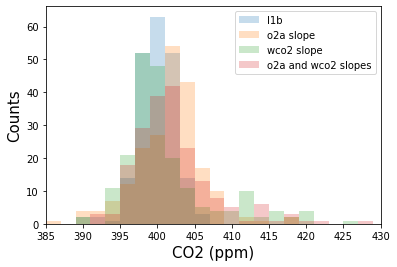

In [251]:
r = range(385, 435, 2)
plt.hist(h5_xco2_retrieved_unpert, bins=r, label='l1b', alpha=0.25)
plt.hist(h5_xco2_retrieved_o2a, bins=r, label='o2a slope', alpha=0.25)
plt.hist(h5_xco2_retrieved_wco2, bins=r, label='wco2 slope', alpha=0.25)
plt.hist(h5_xco2_retrieved_o2a_wco2, bins=r, label='o2a and wco2 slopes', alpha=0.25)

plt.legend()
plt.xlabel('CO2 (ppm)', fontsize=label_size)
plt.ylabel('Counts', fontsize=label_size)
plt.xlim(385, 430)
plt.show()

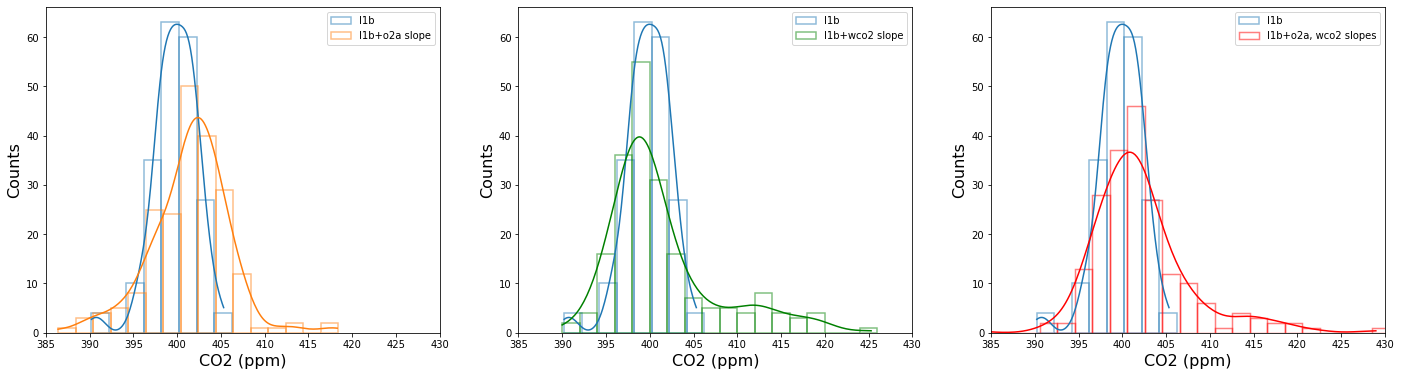

In [240]:
fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6), sharex=False)
properties = {"kde":True, 
              "fill":False,
              #"bins":25,
              "binwidth":2,
              "alpha":0.5}
label_size = 16
sns.histplot(h5_xco2_retrieved_unpert, ax=ax, label='l1b', **properties)
sns.histplot(h5_xco2_retrieved_unpert, ax=ax2, label='l1b', **properties)
sns.histplot(h5_xco2_retrieved_unpert, ax=ax3, label='l1b', **properties)
sns.histplot(h5_xco2_retrieved_o2a, ax=ax, label='l1b+o2a slope', **properties)
sns.histplot(h5_xco2_retrieved_wco2, ax=ax2, label='l1b+wco2 slope', color='g',**properties)
sns.histplot(h5_xco2_retrieved_o2a_wco2, ax=ax3, label='l1b+o2a, wco2 slopes', color='r', **properties)
ax.set_xlabel('CO2 (ppm)', fontsize=label_size)
ax.set_ylabel('Counts', fontsize=label_size)
ax2.set_xlabel('CO2 (ppm)', fontsize=label_size)
ax2.set_ylabel('Counts', fontsize=label_size)
ax3.set_xlabel('CO2 (ppm)', fontsize=label_size)
ax3.set_ylabel('Counts', fontsize=label_size)
ax.legend()
ax2.legend()
ax3.legend()
ax.set_xlim(385, 430)
ax2.set_xlim(385, 430)
ax3.set_xlim(385, 430)
plt.show()

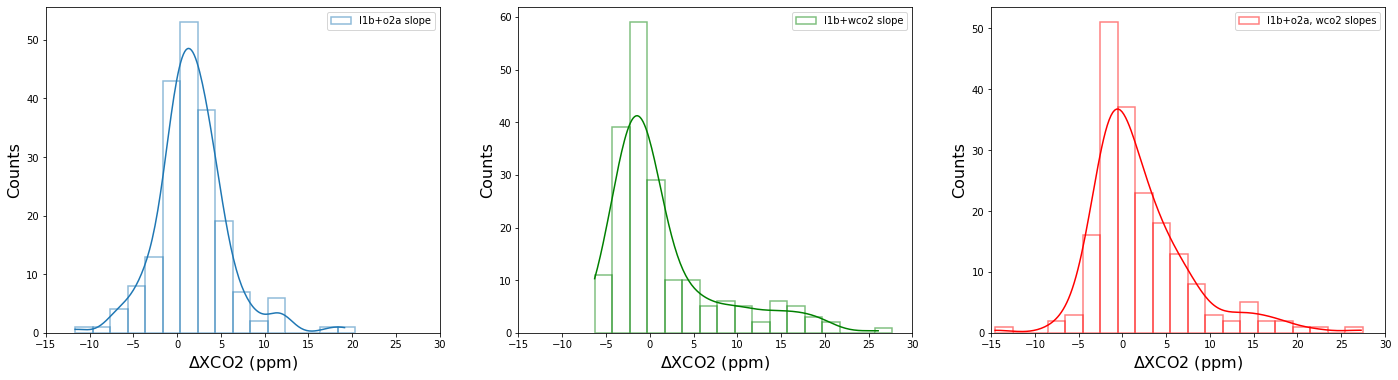

In [239]:
fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6), sharex=False)
properties = {"kde":True, 
              "fill":False,
              #"bins":25,
              "binwidth":2,
              "alpha":0.5}
label_size = 16
#sns.histplot(h5_xco2_retrieved_unpert, ax=ax, label='l1b', **properties)
#sns.histplot(h5_xco2_retrieved_unpert, ax=ax2, label='l1b', **properties)
#sns.histplot(h5_xco2_retrieved_unpert, ax=ax3, label='l1b', **properties)
sns.histplot(del_XCO2_o2a, ax=ax, label='l1b+o2a slope', **properties)
sns.histplot(del_XCO2_wco2, ax=ax2, label='l1b+wco2 slope', color='g',**properties)
sns.histplot(del_XCO2_o2a_wco2, ax=ax3, label='l1b+o2a, wco2 slopes', color='r', **properties)
ax.set_xlabel('$\Delta$XCO2 (ppm)', fontsize=label_size)
ax.set_ylabel('Counts', fontsize=label_size)
ax2.set_xlabel('$\Delta$XCO2 (ppm)', fontsize=label_size)
ax2.set_ylabel('Counts', fontsize=label_size)
ax3.set_xlabel('$\Delta$XCO2 (ppm)', fontsize=label_size)
ax3.set_ylabel('Counts', fontsize=label_size)
ax.legend()
ax2.legend()
ax3.legend()
ax.set_xlim(-15, 30)
ax2.set_xlim(-15, 30)
ax3.set_xlim(-15, 30)
plt.show()

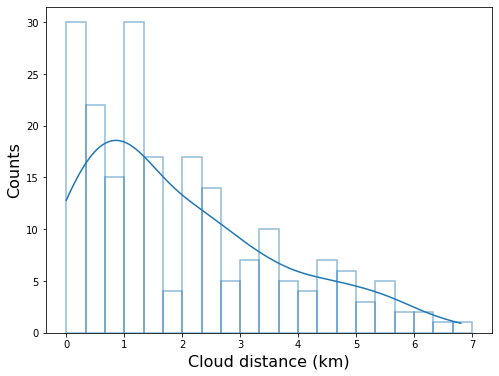

In [257]:
fig, (ax) = plt.subplots(1, 1, figsize=(8, 6), sharex=False)
properties = {"kde":True, 
              "fill":False,
              #"bins":25,
              "binwidth":1/3,
              "alpha":0.5}
label_size = 16
#sns.histplot(h5_xco2_retrieved_unpert, ax=ax, label='l1b', **properties)
#sns.histplot(h5_xco2_retrieved_unpert, ax=ax2, label='l1b', **properties)
#sns.histplot(h5_xco2_retrieved_unpert, ax=ax3, label='l1b', **properties)
sns.histplot(cld_list, ax=ax, label='l1b+o2a slope', **properties)

ax.set_xlabel('Cloud distance (km)', fontsize=label_size)
ax.set_ylabel('Counts', fontsize=label_size)

#ax.legend()

#ax.set_xlim(-15, 30)

plt.show()

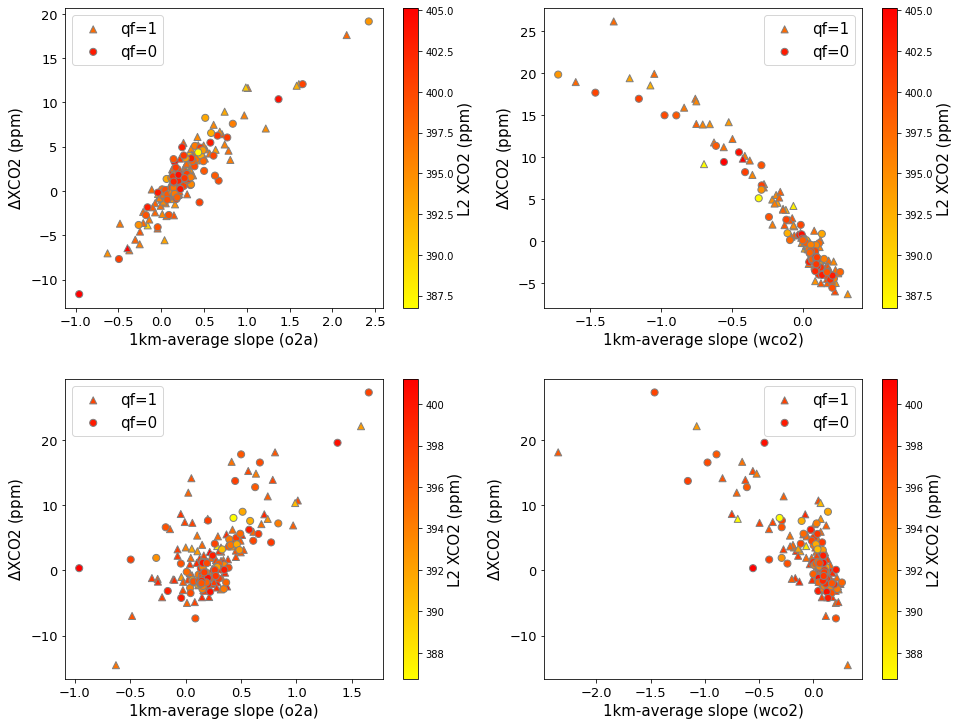

In [241]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(14, 11), sharex=False)
fig.tight_layout(pad=5.0)
light_jet = cm.jet#cmap_map(lambda x: x/3 + 0.66, cm.jet)
subfig_index = ['a', 'b', 'c', 'd', 'e', 'f']
ax_list = [ax11, ax12, ax21, ax22]
title_size = 18
label_size = 15
tick_size = 13
xy_list = [(o1_s, del_XCO2_o2a), (o2_s, del_XCO2_wco2), (o1_s, del_XCO2_o2a_wco2), (o2_s, del_XCO2_o2a_wco2),]
c_list = [h5_xco2_L2_file_o2a]*4
x_label = ['1km-average slope (o2a)', '1km-average slope (wco2)', 
           '1km-average slope (o2a)', '1km-average slope (wco2)',]
y_label = ['$\Delta$XCO2 (ppm)']*4
cbar_label = ['L2 XCO2 (ppm)']*4

qf0 = np.array(qf_list)==0
qf1 = np.array(qf_list)==1
OCO_class_list = [o1, o2]
#ax11.scatter(cld_array[:, :, 0][qf0], o1.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='1 km points (qf=0)')
#ax21.scatter(cld_array[:, :, 0][qf0], o2.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='s25 points (qf=0)')
susan_col = ['o2a_slope', 'wco2_sope']
color_list= ['tab:blue', 'tab:red']
#
for i in range(4):
    ax = ax_list[i]
    x, y = np.array(xy_list[i][0]), np.array(xy_list[i][1])
    mask = ~np.isnan(x) & ~np.isnan(y)
    
    sca = ax.scatter(x[qf1], y[qf1], s=50, marker='^', c=np.array(c_list[i])[qf1], alpha=1, label='qf=1', cmap='autumn_r', edgecolor='grey')
    ax.scatter(x[qf0], y[qf0], s=50, marker='o', c=np.array(c_list[i])[qf0], alpha=1, label='qf=0', cmap='autumn_r', edgecolor='grey')
    
    ax.set_ylabel(y_label[i], fontsize=label_size)
    ax.set_xlabel(x_label[i], fontsize=label_size)
    #ax.set_xticks(range(0, 160, 20))
    ax.xaxis.set_tick_params(labelsize=tick_size)
    ax.yaxis.set_tick_params(labelsize=tick_size)

    #ymin, ymax = -0.75, 0.75
    #xmin, xmax = -0.75, 0.75
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    #ax.plot([xmin, xmax],[0,0],'k--')
    #ax.plot([0, 0],[ymin, ymax],'k--')
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    #ax.text((xmin+(xmax-xmin)*0.45), (ymin+(ymax-ymin)*0.1),
    #        f'y = {a:.2f} x exp(-{b:.2f}x)', fontsize=14)
    #ax.plot([-1, 1, 1, -1, -1], [-1, -1, 1, 1, -1], 'k-')
    #ax.text((xmin+(xmax-xmin)*0.05), (ymin+(ymax-ymin)*0.9),
    #        '({})'.format(subfig_index[i]), fontsize=18, fontweight='bold')
    ax.legend(fontsize=15)
    cbar = fig.colorbar(sca, ax=ax)#, location='bottom')
    cbar.set_label(cbar_label[i], fontsize=15)
#ax11.set_ylabel('O2A slope', fontsize=label_size)
#ax21.set_ylabel('WCO2 slope', fontsize=label_size)
#ax11.set_title('O2A slope', fontsize=title_size)
#ax21.set_title('WCO2 slope', fontsize=title_size)
#fig.suptitle('qf=0', y=1.01, fontsize=title_size+2)
plt.show()

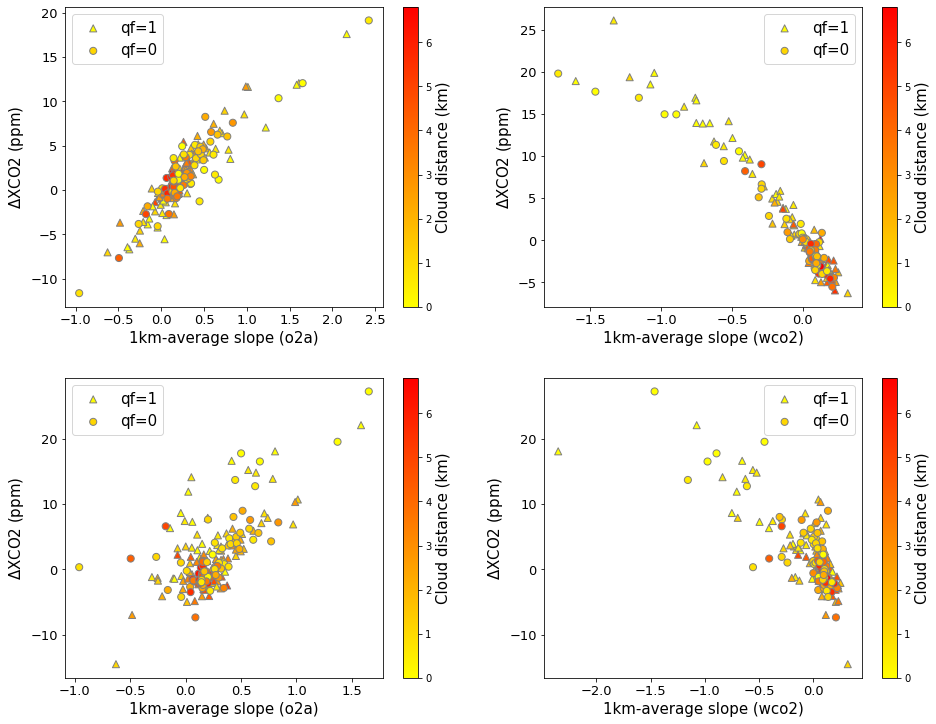

In [242]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(14, 11), sharex=False)
fig.tight_layout(pad=5.0)
light_jet = cm.jet#cmap_map(lambda x: x/3 + 0.66, cm.jet)
subfig_index = ['a', 'b', 'c', 'd', 'e', 'f']
ax_list = [ax11, ax12, ax21, ax22]
title_size = 18
label_size = 15
tick_size = 13
xy_list = [(o1_s, del_XCO2_o2a), (o2_s, del_XCO2_wco2), (o1_s, del_XCO2_o2a_wco2), (o2_s, del_XCO2_o2a_wco2),]
c_list = [cld_list, cld_list, cld_list, cld_list]
x_label = ['1km-average slope (o2a)', '1km-average slope (wco2)', 
           '1km-average slope (o2a)', '1km-average slope (wco2)',]
y_label = ['$\Delta$XCO2 (ppm)']*4
cbar_label = ['Cloud distance (km)']*4

qf0 = np.array(qf_list)==0
qf1 = np.array(qf_list)==1
OCO_class_list = [o1, o2]
#ax11.scatter(cld_array[:, :, 0][qf0], o1.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='1 km points (qf=0)')
#ax21.scatter(cld_array[:, :, 0][qf0], o2.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='s25 points (qf=0)')
susan_col = ['o2a_slope', 'wco2_sope']
color_list= ['tab:blue', 'tab:red']
#
for i in range(4):
    ax = ax_list[i]
    x, y = np.array(xy_list[i][0]), np.array(xy_list[i][1])
    mask = ~np.isnan(x) & ~np.isnan(y)
    
    sca = ax.scatter(x[qf1], y[qf1], s=50, marker='^', c=np.array(c_list[i])[qf1], alpha=1, label='qf=1', cmap='autumn_r', edgecolor='grey')
    ax.scatter(x[qf0], y[qf0], s=50, marker='o', c=np.array(c_list[i])[qf0], alpha=1, label='qf=0', cmap='autumn_r', edgecolor='grey')
    
    ax.set_ylabel(y_label[i], fontsize=label_size)
    ax.set_xlabel(x_label[i], fontsize=label_size)
    #ax.set_xticks(range(0, 160, 20))
    ax.xaxis.set_tick_params(labelsize=tick_size)
    ax.yaxis.set_tick_params(labelsize=tick_size)

    #ymin, ymax = -0.75, 0.75
    #xmin, xmax = -0.75, 0.75
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    #ax.plot([xmin, xmax],[0,0],'k--')
    #ax.plot([0, 0],[ymin, ymax],'k--')
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    #ax.text((xmin+(xmax-xmin)*0.45), (ymin+(ymax-ymin)*0.1),
    #        f'y = {a:.2f} x exp(-{b:.2f}x)', fontsize=14)
    #ax.plot([-1, 1, 1, -1, -1], [-1, -1, 1, 1, -1], 'k-')
    #ax.text((xmin+(xmax-xmin)*0.05), (ymin+(ymax-ymin)*0.9),
    #        '({})'.format(subfig_index[i]), fontsize=18, fontweight='bold')
    ax.legend(fontsize=15)
    cbar = fig.colorbar(sca, ax=ax)#, location='bottom')
    cbar.set_label(cbar_label[i], fontsize=15)
#ax11.set_ylabel('O2A slope', fontsize=label_size)
#ax21.set_ylabel('WCO2 slope', fontsize=label_size)
#ax11.set_title('O2A slope', fontsize=title_size)
#ax21.set_title('WCO2 slope', fontsize=title_size)
#fig.suptitle('qf=0', y=1.01, fontsize=title_size+2)
plt.show()

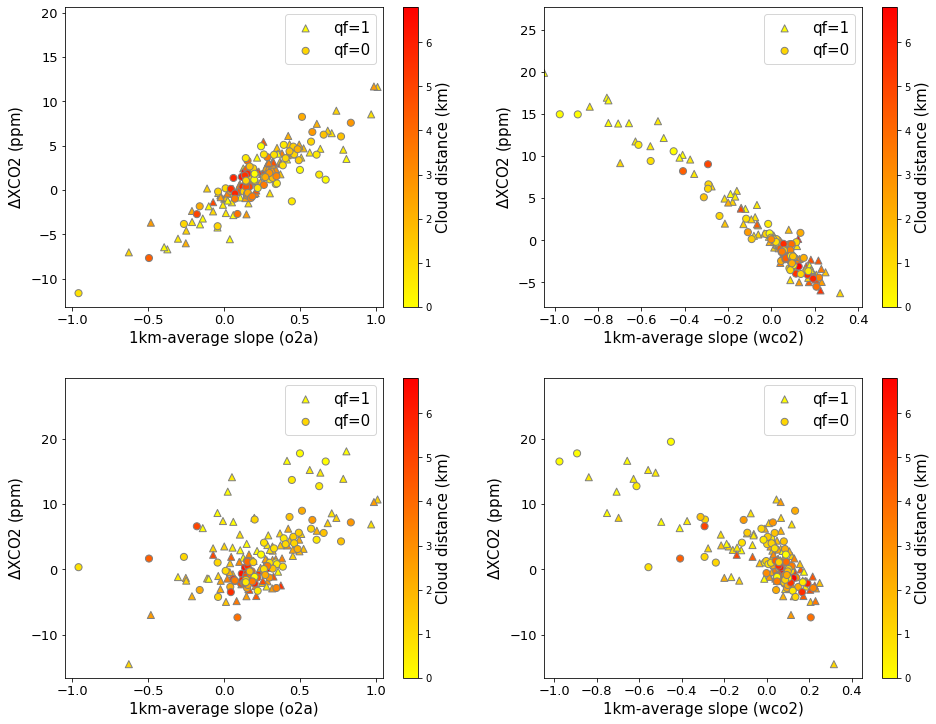

In [243]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(14, 11), sharex=False)
fig.tight_layout(pad=5.0)
light_jet = cm.jet#cmap_map(lambda x: x/3 + 0.66, cm.jet)
subfig_index = ['a', 'b', 'c', 'd', 'e', 'f']
ax_list = [ax11, ax12, ax21, ax22]
title_size = 18
label_size = 15
tick_size = 13
xy_list = [(o1_s, del_XCO2_o2a), (o2_s, del_XCO2_wco2), (o1_s, del_XCO2_o2a_wco2), (o2_s, del_XCO2_o2a_wco2),]
c_list = [cld_list, cld_list, cld_list, cld_list]
x_label = ['1km-average slope (o2a)', '1km-average slope (wco2)', 
           '1km-average slope (o2a)', '1km-average slope (wco2)',]
y_label = ['$\Delta$XCO2 (ppm)']*4
cbar_label = ['Cloud distance (km)']*4

qf0 = np.array(qf_list)==0
qf1 = np.array(qf_list)==1
OCO_class_list = [o1, o2]
#ax11.scatter(cld_array[:, :, 0][qf0], o1.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='1 km points (qf=0)')
#ax21.scatter(cld_array[:, :, 0][qf0], o2.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='s25 points (qf=0)')
susan_col = ['o2a_slope', 'wco2_sope']
color_list= ['tab:blue', 'tab:red']
#
for i in range(4):
    ax = ax_list[i]
    x, y = np.array(xy_list[i][0]), np.array(xy_list[i][1])
    mask = ~np.isnan(x) & ~np.isnan(y)
    
    sca = ax.scatter(x[qf1], y[qf1], s=50, marker='^', c=np.array(c_list[i])[qf1], alpha=1, label='qf=1', cmap='autumn_r', edgecolor='grey')
    ax.scatter(x[qf0], y[qf0], s=50, marker='o', c=np.array(c_list[i])[qf0], alpha=1, label='qf=0', cmap='autumn_r', edgecolor='grey')
    
    ax.set_ylabel(y_label[i], fontsize=label_size)
    ax.set_xlabel(x_label[i], fontsize=label_size)
    #ax.set_xticks(range(0, 160, 20))
    ax.xaxis.set_tick_params(labelsize=tick_size)
    ax.yaxis.set_tick_params(labelsize=tick_size)

    #ymin, ymax = -0.75, 0.75
    #xmin, xmax = -0.75, 0.75
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    if xmin < -1:
        xmin = -1.05
    if xmax > 1:
        xmax = 1.05
    #ax.plot([xmin, xmax],[0,0],'k--')
    #ax.plot([0, 0],[ymin, ymax],'k--')
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    #ax.text((xmin+(xmax-xmin)*0.45), (ymin+(ymax-ymin)*0.1),
    #        f'y = {a:.2f} x exp(-{b:.2f}x)', fontsize=14)
    #ax.plot([-1, 1, 1, -1, -1], [-1, -1, 1, 1, -1], 'k-')
    #ax.text((xmin+(xmax-xmin)*0.05), (ymin+(ymax-ymin)*0.9),
    #        '({})'.format(subfig_index[i]), fontsize=18, fontweight='bold')
    ax.legend(fontsize=15)
    cbar = fig.colorbar(sca, ax=ax)#, location='bottom')
    cbar.set_label(cbar_label[i], fontsize=15)
#ax11.set_ylabel('O2A slope', fontsize=label_size)
#ax21.set_ylabel('WCO2 slope', fontsize=label_size)
#ax11.set_title('O2A slope', fontsize=title_size)
#ax21.set_title('WCO2 slope', fontsize=title_size)
#fig.suptitle('qf=0', y=1.01, fontsize=title_size+2)
plt.show()

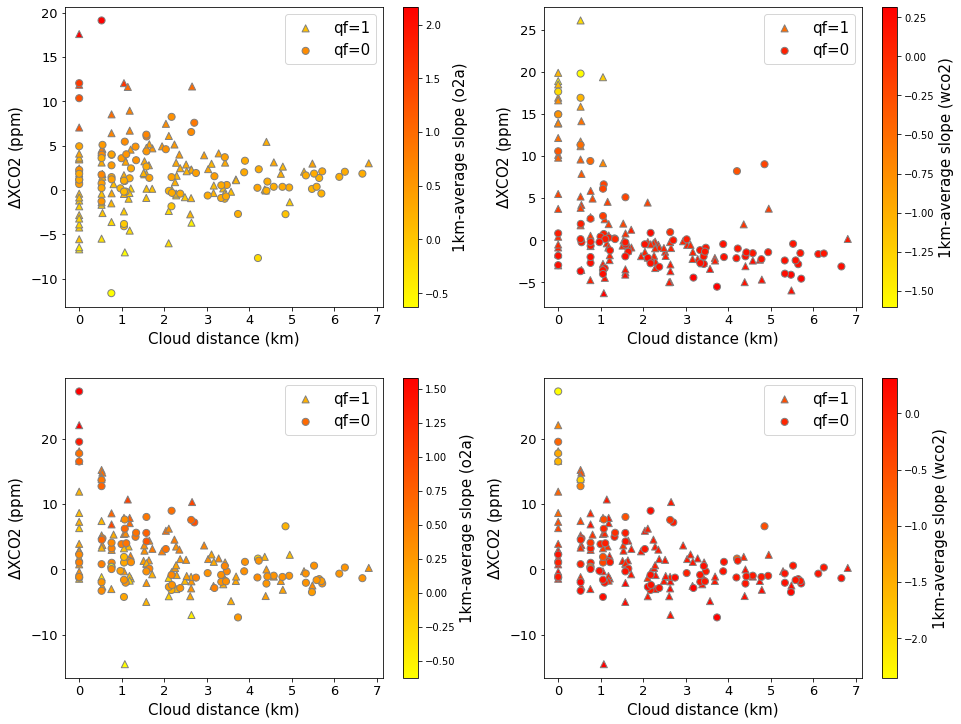

In [244]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(14, 11), sharex=False)
fig.tight_layout(pad=5.0)
light_jet = cm.jet#cmap_map(lambda x: x/3 + 0.66, cm.jet)
subfig_index = ['a', 'b', 'c', 'd', 'e', 'f']
ax_list = [ax11, ax12, ax21, ax22]
title_size = 18
label_size = 15
tick_size = 13
xy_list = [(cld_list, del_XCO2_o2a), (cld_list, del_XCO2_wco2), (cld_list, del_XCO2_o2a_wco2), (cld_list, del_XCO2_o2a_wco2),]
c_list = [o1_s, o2_s, o1_s, o2_s]
cbar_label = ['1km-average slope (o2a)', '1km-average slope (wco2)', 
           '1km-average slope (o2a)', '1km-average slope (wco2)',]
y_label = ['$\Delta$XCO2 (ppm)']*4
x_label = ['Cloud distance (km)']*4

qf0 = np.array(qf_list)==0
qf1 = np.array(qf_list)==1
OCO_class_list = [o1, o2]
#ax11.scatter(cld_array[:, :, 0][qf0], o1.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='1 km points (qf=0)')
#ax21.scatter(cld_array[:, :, 0][qf0], o2.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='s25 points (qf=0)')
susan_col = ['o2a_slope', 'wco2_sope']
color_list= ['tab:blue', 'tab:red']
#
for i in range(4):
    ax = ax_list[i]
    x, y = np.array(xy_list[i][0]), np.array(xy_list[i][1])
    mask = ~np.isnan(x) & ~np.isnan(y)
    
    sca = ax.scatter(x[qf1], y[qf1], s=50, marker='^', c=np.array(c_list[i])[qf1], alpha=1, label='qf=1', cmap='autumn_r', edgecolor='grey')
    ax.scatter(x[qf0], y[qf0], s=50, marker='o', c=np.array(c_list[i])[qf0], alpha=1, label='qf=0', cmap='autumn_r', edgecolor='grey')
    
    ax.set_ylabel(y_label[i], fontsize=label_size)
    ax.set_xlabel(x_label[i], fontsize=label_size)
    #ax.set_xticks(range(0, 160, 20))
    ax.xaxis.set_tick_params(labelsize=tick_size)
    ax.yaxis.set_tick_params(labelsize=tick_size)

    #ymin, ymax = -0.75, 0.75
    #xmin, xmax = -0.75, 0.75
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()

    #ax.plot([xmin, xmax],[0,0],'k--')
    #ax.plot([0, 0],[ymin, ymax],'k--')
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    #ax.text((xmin+(xmax-xmin)*0.45), (ymin+(ymax-ymin)*0.1),
    #        f'y = {a:.2f} x exp(-{b:.2f}x)', fontsize=14)
    #ax.plot([-1, 1, 1, -1, -1], [-1, -1, 1, 1, -1], 'k-')
    #ax.text((xmin+(xmax-xmin)*0.05), (ymin+(ymax-ymin)*0.9),
    #        '({})'.format(subfig_index[i]), fontsize=18, fontweight='bold')
    ax.legend(fontsize=15)
    cbar = fig.colorbar(sca, ax=ax)#, location='bottom')
    cbar.set_label(cbar_label[i], fontsize=15)
#ax11.set_ylabel('O2A slope', fontsize=label_size)
#ax21.set_ylabel('WCO2 slope', fontsize=label_size)
#ax11.set_title('O2A slope', fontsize=title_size)
#ax21.set_title('WCO2 slope', fontsize=title_size)
#fig.suptitle('qf=0', y=1.01, fontsize=title_size+2)
plt.show()

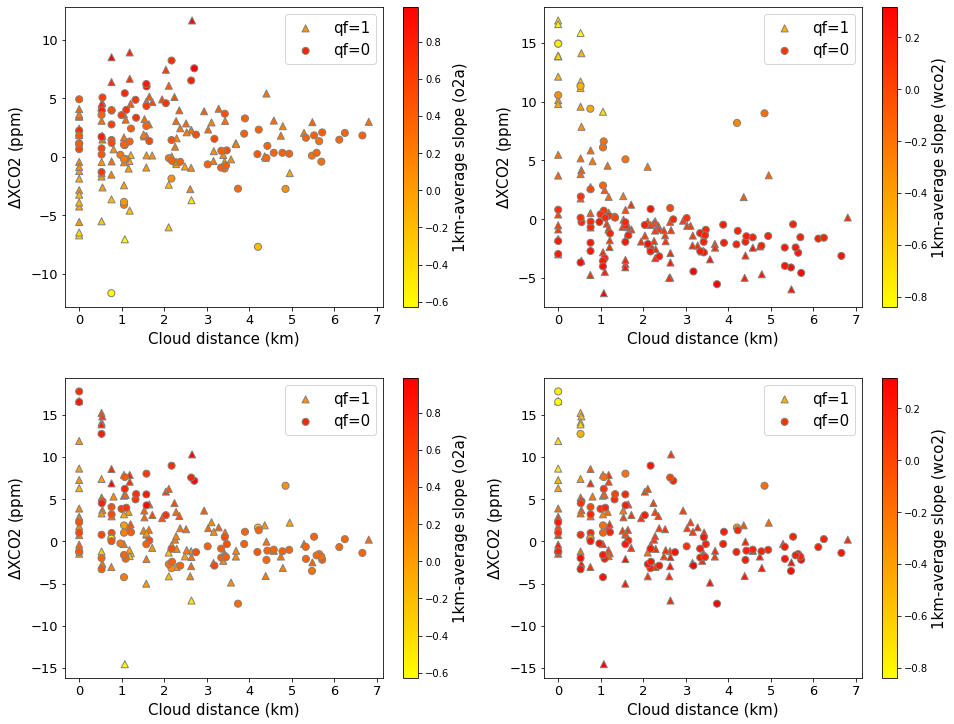

In [245]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(14, 11), sharex=False)
fig.tight_layout(pad=5.0)
light_jet = cm.jet#cmap_map(lambda x: x/3 + 0.66, cm.jet)
subfig_index = ['a', 'b', 'c', 'd', 'e', 'f']
ax_list = [ax11, ax12, ax21, ax22]
title_size = 18
label_size = 15
tick_size = 13
o1s_mask = np.logical_and(o1_s<=1, o1_s>=-1)
o2s_mask = np.logical_and(o2_s<=1, o2_s>=-1)
both_mask = np.logical_and(o1s_mask, o2s_mask)
xy_list = [(cld_list[o1s_mask], del_XCO2_o2a[o1s_mask]), (cld_list[o2s_mask], del_XCO2_wco2[o2s_mask]), 
           (cld_list[both_mask], del_XCO2_o2a_wco2[both_mask]), (cld_list[both_mask], del_XCO2_o2a_wco2[both_mask]),]
c_list = [o1_s[o1s_mask], o2_s[o2s_mask], o1_s[both_mask], o2_s[both_mask]]
cbar_label = ['1km-average slope (o2a)', '1km-average slope (wco2)', 
           '1km-average slope (o2a)', '1km-average slope (wco2)',]
y_label = ['$\Delta$XCO2 (ppm)']*4
x_label = ['Cloud distance (km)']*4

qf0 = [np.array(qf_list[o1s_mask])==0, np.array(qf_list[o2s_mask])==0,
       np.array(qf_list[both_mask])==0, np.array(qf_list[both_mask])==0]
qf1 = [np.array(qf_list[o1s_mask])==1, np.array(qf_list[o2s_mask])==1,
       np.array(qf_list[both_mask])==1, np.array(qf_list[both_mask])==1]
OCO_class_list = [o1, o2]
#ax11.scatter(cld_array[:, :, 0][qf0], o1.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='1 km points (qf=0)')
#ax21.scatter(cld_array[:, :, 0][qf0], o2.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='s25 points (qf=0)')
susan_col = ['o2a_slope', 'wco2_sope']
color_list= ['tab:blue', 'tab:red']
#
for i in range(4):
    ax = ax_list[i]
    x, y = np.array(xy_list[i][0]), np.array(xy_list[i][1])
    mask = ~np.isnan(x) & ~np.isnan(y)
    
    sca = ax.scatter(x[qf1[i]], y[qf1[i]], s=50, marker='^', c=np.array(c_list[i])[qf1[i]], alpha=1, label='qf=1', cmap='autumn_r', edgecolor='grey')
    ax.scatter(x[qf0[i]], y[qf0[i]], s=50, marker='o', c=np.array(c_list[i])[qf0[i]], alpha=1, label='qf=0', cmap='autumn_r', edgecolor='grey')
    
    ax.set_ylabel(y_label[i], fontsize=label_size)
    ax.set_xlabel(x_label[i], fontsize=label_size)
    #ax.set_xticks(range(0, 160, 20))
    ax.xaxis.set_tick_params(labelsize=tick_size)
    ax.yaxis.set_tick_params(labelsize=tick_size)

    #ymin, ymax = -0.75, 0.75
    #xmin, xmax = -0.75, 0.75
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()

    #ax.plot([xmin, xmax],[0,0],'k--')
    #ax.plot([0, 0],[ymin, ymax],'k--')
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    #ax.text((xmin+(xmax-xmin)*0.45), (ymin+(ymax-ymin)*0.1),
    #        f'y = {a:.2f} x exp(-{b:.2f}x)', fontsize=14)
    #ax.plot([-1, 1, 1, -1, -1], [-1, -1, 1, 1, -1], 'k-')
    #ax.text((xmin+(xmax-xmin)*0.05), (ymin+(ymax-ymin)*0.9),
    #        '({})'.format(subfig_index[i]), fontsize=18, fontweight='bold')
    ax.legend(fontsize=15)
    cbar = fig.colorbar(sca, ax=ax)#, location='bottom')
    cbar.set_label(cbar_label[i], fontsize=15)
#ax11.set_ylabel('O2A slope', fontsize=label_size)
#ax21.set_ylabel('WCO2 slope', fontsize=label_size)
#ax11.set_title('O2A slope', fontsize=title_size)
#ax21.set_title('WCO2 slope', fontsize=title_size)
#fig.suptitle('qf=0', y=1.01, fontsize=title_size+2)
plt.show()

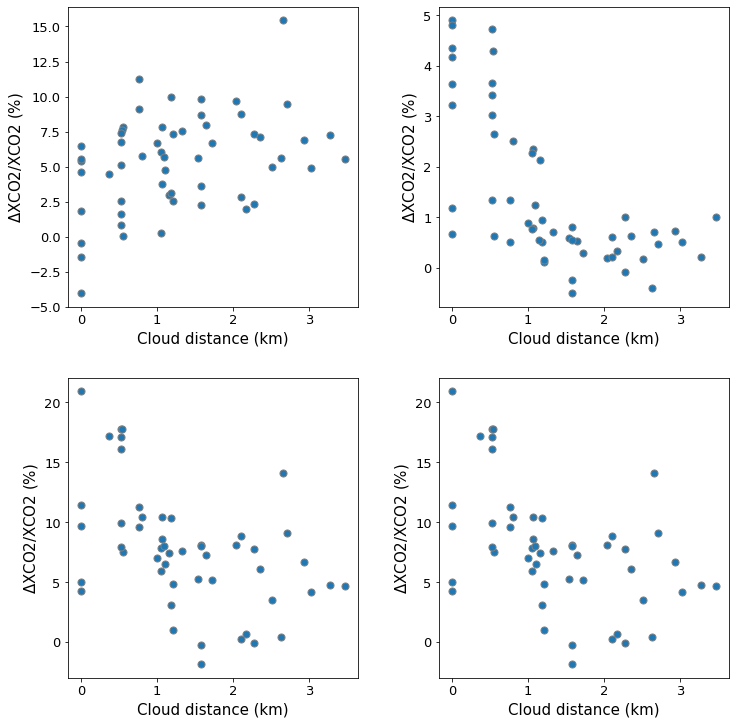

In [136]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(11, 11), sharex=False)
fig.tight_layout(pad=5.0)
light_jet = cm.jet#cmap_map(lambda x: x/3 + 0.66, cm.jet)
subfig_index = ['a', 'b', 'c', 'd', 'e', 'f']
ax_list = [ax11, ax12, ax21, ax22]
title_size = 18
label_size = 15
tick_size = 13
o1s_mask = np.logical_and(o1_s<=1, o1_s>=-1)
o2s_mask = np.logical_and(o2_s<=1, o2_s>=-1)
both_mask = np.logical_and(o1s_mask, o2s_mask)
xy_list = [(cld_list[o1s_mask], del_XCO2_o2a[o1s_mask]), (cld_list[o2s_mask], del_XCO2_wco2[o2s_mask]/h5_xco2_retrieved_unpert[o2s_mask]*100), 
           (cld_list[both_mask], del_XCO2_o2a_wco2[both_mask]), (cld_list[both_mask], del_XCO2_o2a_wco2[both_mask]),]
c_list = [o1_s[o1s_mask], o2_s[o2s_mask], o1_s[both_mask], o2_s[both_mask]]
cbar_label = ['1km-average slope (o2a)', '1km-average slope (wco2)', 
           '1km-average slope (o2a)', '1km-average slope (wco2)',]
y_label = ['$\Delta$XCO2/XCO2 (%)']*4
x_label = ['Cloud distance (km)']*4

qf0 = [np.array(qf_list[o1s_mask])==0, np.array(qf_list[o2s_mask])==0,
       np.array(qf_list[both_mask])==0, np.array(qf_list[both_mask])==0]
qf1 = [np.array(qf_list[o1s_mask])==1, np.array(qf_list[o2s_mask])==1,
       np.array(qf_list[both_mask])==1, np.array(qf_list[both_mask])==1]
OCO_class_list = [o1, o2]
#ax11.scatter(cld_array[:, :, 0][qf0], o1.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='1 km points (qf=0)')
#ax21.scatter(cld_array[:, :, 0][qf0], o2.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='s25 points (qf=0)')
susan_col = ['o2a_slope', 'wco2_sope']
color_list= ['tab:blue', 'tab:red']
#
for i in range(4):
    ax = ax_list[i]
    x, y = np.array(xy_list[i][0]), np.array(xy_list[i][1])
    mask = ~np.isnan(x) & ~np.isnan(y)
    
    sca = ax.scatter(x, y, s=50, alpha=1, edgecolor='grey')
        
    ax.set_ylabel(y_label[i], fontsize=label_size)
    ax.set_xlabel(x_label[i], fontsize=label_size)
    #ax.set_xticks(range(0, 160, 20))
    ax.xaxis.set_tick_params(labelsize=tick_size)
    ax.yaxis.set_tick_params(labelsize=tick_size)

    #ymin, ymax = -0.75, 0.75
    #xmin, xmax = -0.75, 0.75
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()

    #ax.plot([xmin, xmax],[0,0],'k--')
    #ax.plot([0, 0],[ymin, ymax],'k--')
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    #ax.text((xmin+(xmax-xmin)*0.45), (ymin+(ymax-ymin)*0.1),
    #        f'y = {a:.2f} x exp(-{b:.2f}x)', fontsize=14)
    #ax.plot([-1, 1, 1, -1, -1], [-1, -1, 1, 1, -1], 'k-')
    #ax.text((xmin+(xmax-xmin)*0.05), (ymin+(ymax-ymin)*0.9),
    #        '({})'.format(subfig_index[i]), fontsize=18, fontweight='bold')
    #ax.legend(fontsize=15)
    #cbar = fig.colorbar(sca, ax=ax)#, location='bottom')
    #cbar.set_label(cbar_label[i], fontsize=15)
#ax11.set_ylabel('O2A slope', fontsize=label_size)
#ax21.set_ylabel('WCO2 slope', fontsize=label_size)
#ax11.set_title('O2A slope', fontsize=title_size)
#ax21.set_title('WCO2 slope', fontsize=title_size)
#fig.suptitle('qf=0', y=1.01, fontsize=title_size+2)
plt.show()

In [110]:
c_list[0].shape

(57,)

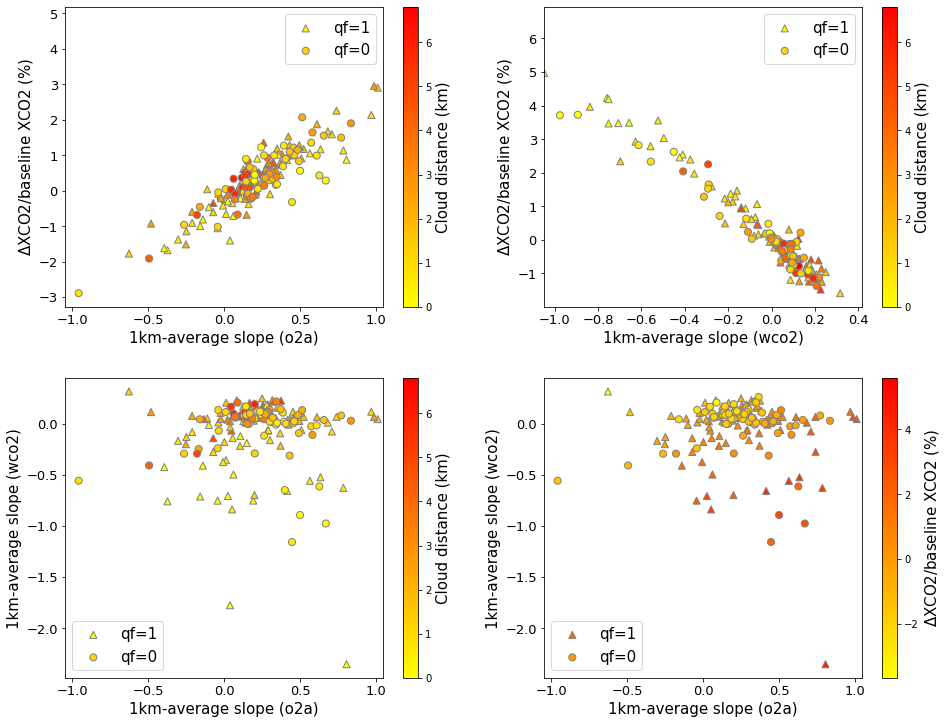

In [277]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(14, 11), sharex=False)
fig.tight_layout(pad=5.0)
light_jet = cm.jet#cmap_map(lambda x: x/3 + 0.66, cm.jet)
subfig_index = ['a', 'b', 'c', 'd', 'e', 'f']
ax_list = [ax11, ax12, ax21, ax22]
title_size = 18
label_size = 15
tick_size = 13
xy_list = [(o1_s, del_XCO2_o2a/h5_xco2_retrieved_unpert*100),
           (o2_s, del_XCO2_wco2/h5_xco2_retrieved_unpert*100),
           (o1_s, o2_s),
           (o1_s, o2_s),]
c_list = [cld_list, cld_list, cld_list, del_XCO2_o2a_wco2/h5_xco2_retrieved_unpert*100]
x_label = ['1km-average slope (o2a)', '1km-average slope (wco2)', 
           '1km-average slope (o2a)', '1km-average slope (o2a)',]
y_label = ['$\Delta$XCO2/baseline XCO2 (%)', '$\Delta$XCO2/baseline XCO2 (%)',
           '1km-average slope (wco2)', '1km-average slope (wco2)',]
cbar_label = ['Cloud distance (km)']*3 + ['$\Delta$XCO2/baseline XCO2 (%)']

qf0 = np.array(qf_list)==0
qf1 = np.array(qf_list)==1
OCO_class_list = [o1, o2]
#ax11.scatter(cld_array[:, :, 0][qf0], o1.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='1 km points (qf=0)')
#ax21.scatter(cld_array[:, :, 0][qf0], o2.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='s25 points (qf=0)')
susan_col = ['o2a_slope', 'wco2_sope']
color_list= ['tab:blue', 'tab:red']
#
for i in range(4):
    ax = ax_list[i]
    x, y = np.array(xy_list[i][0]), np.array(xy_list[i][1])
    mask = ~np.isnan(x) & ~np.isnan(y)
    
    sca = ax.scatter(x[qf1], y[qf1], s=50, marker='^', c=np.array(c_list[i])[qf1], alpha=1, label='qf=1', cmap='autumn_r', edgecolor='grey')
    ax.scatter(x[qf0], y[qf0], s=50, marker='o', c=np.array(c_list[i])[qf0], alpha=1, label='qf=0', cmap='autumn_r', edgecolor='grey')
    
    ax.set_ylabel(y_label[i], fontsize=label_size)
    ax.set_xlabel(x_label[i], fontsize=label_size)
    #ax.set_xticks(range(0, 160, 20))
    ax.xaxis.set_tick_params(labelsize=tick_size)
    ax.yaxis.set_tick_params(labelsize=tick_size)

    #ymin, ymax = -0.75, 0.75
    #xmin, xmax = -0.75, 0.75
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    if xmin < -1:
        xmin = -1.05
    if xmax > 1:
        xmax = 1.05
    #ax.plot([xmin, xmax],[0,0],'k--')
    #ax.plot([0, 0],[ymin, ymax],'k--')
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    #ax.text((xmin+(xmax-xmin)*0.45), (ymin+(ymax-ymin)*0.1),
    #        f'y = {a:.2f} x exp(-{b:.2f}x)', fontsize=14)
    #ax.plot([-1, 1, 1, -1, -1], [-1, -1, 1, 1, -1], 'k-')
    #ax.text((xmin+(xmax-xmin)*0.05), (ymin+(ymax-ymin)*0.9),
    #        '({})'.format(subfig_index[i]), fontsize=18, fontweight='bold')
    ax.legend(fontsize=15)
    cbar = fig.colorbar(sca, ax=ax)#, location='bottom')
    cbar.set_label(cbar_label[i], fontsize=15)
#ax11.set_ylabel('O2A slope', fontsize=label_size)
#ax21.set_ylabel('WCO2 slope', fontsize=label_size)
#ax11.set_title('O2A slope', fontsize=title_size)
#ax21.set_title('WCO2 slope', fontsize=title_size)
#fig.suptitle('qf=0', y=1.01, fontsize=title_size+2)
plt.show()

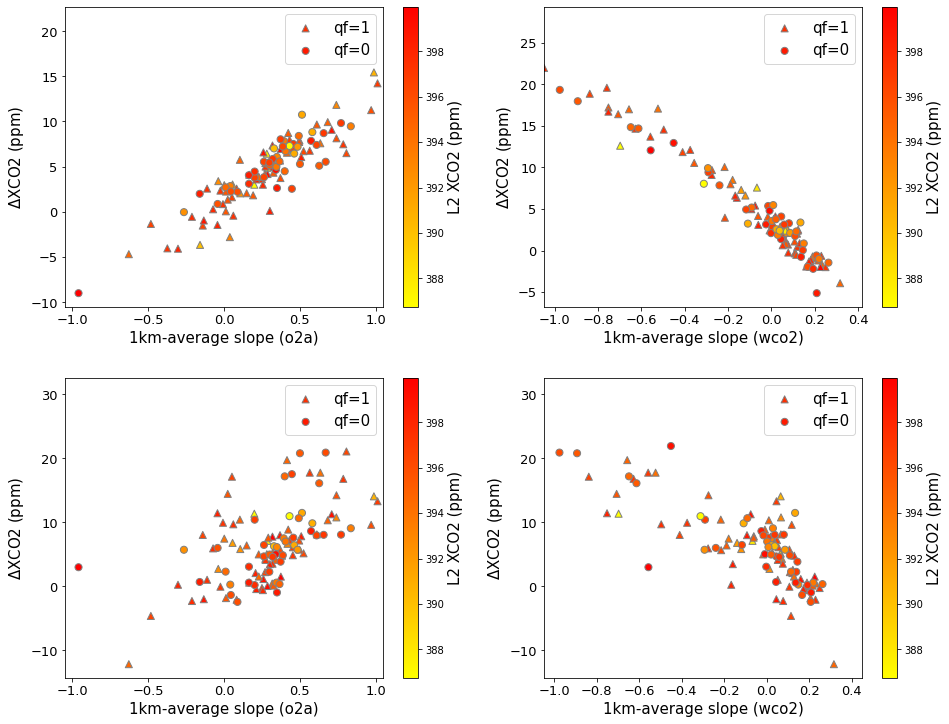

In [194]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(14, 11), sharex=False)
fig.tight_layout(pad=5.0)
light_jet = cm.jet#cmap_map(lambda x: x/3 + 0.66, cm.jet)
subfig_index = ['a', 'b', 'c', 'd', 'e', 'f']
ax_list = [ax11, ax12, ax21, ax22]
title_size = 18
label_size = 15
tick_size = 13
xy_list = [(o1_s, del_XCO2_o2a), (o2_s, del_XCO2_wco2), (o1_s, del_XCO2_o2a_wco2), (o2_s, del_XCO2_o2a_wco2),]
c_list = [h5_xco2_L2_file_o2a]*4
x_label = ['1km-average slope (o2a)', '1km-average slope (wco2)', 
           '1km-average slope (o2a)', '1km-average slope (wco2)',]
y_label = ['$\Delta$XCO2 (ppm)']*4
cbar_label = ['L2 XCO2 (ppm)']*4

qf0 = np.array(qf_list)==0
qf1 = np.array(qf_list)==1
OCO_class_list = [o1, o2]
#ax11.scatter(cld_array[:, :, 0][qf0], o1.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='1 km points (qf=0)')
#ax21.scatter(cld_array[:, :, 0][qf0], o2.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='s25 points (qf=0)')
susan_col = ['o2a_slope', 'wco2_sope']
color_list= ['tab:blue', 'tab:red']
#
for i in range(4):
    ax = ax_list[i]
    x, y = np.array(xy_list[i][0]), np.array(xy_list[i][1])
    mask = ~np.isnan(x) & ~np.isnan(y)
    
    sca = ax.scatter(x[qf1], y[qf1], s=50, marker='^', c=np.array(c_list[i])[qf1], alpha=1, label='qf=1', cmap='autumn_r', edgecolor='grey')
    ax.scatter(x[qf0], y[qf0], s=50, marker='o', c=np.array(c_list[i])[qf0], alpha=1, label='qf=0', cmap='autumn_r', edgecolor='grey')
    
    ax.set_ylabel(y_label[i], fontsize=label_size)
    ax.set_xlabel(x_label[i], fontsize=label_size)
    #ax.set_xticks(range(0, 160, 20))
    ax.xaxis.set_tick_params(labelsize=tick_size)
    ax.yaxis.set_tick_params(labelsize=tick_size)

    #ymin, ymax = -0.75, 0.75
    #xmin, xmax = -0.75, 0.75
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    if xmin < -1:
        xmin = -1.05
    if xmax > 1:
        xmax = 1.05
    #ax.plot([xmin, xmax],[0,0],'k--')
    #ax.plot([0, 0],[ymin, ymax],'k--')
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    #ax.text((xmin+(xmax-xmin)*0.45), (ymin+(ymax-ymin)*0.1),
    #        f'y = {a:.2f} x exp(-{b:.2f}x)', fontsize=14)
    #ax.plot([-1, 1, 1, -1, -1], [-1, -1, 1, 1, -1], 'k-')
    #ax.text((xmin+(xmax-xmin)*0.05), (ymin+(ymax-ymin)*0.9),
    #        '({})'.format(subfig_index[i]), fontsize=18, fontweight='bold')
    ax.legend(fontsize=15)
    cbar = fig.colorbar(sca, ax=ax)#, location='bottom')
    cbar.set_label(cbar_label[i], fontsize=15)
#ax11.set_ylabel('O2A slope', fontsize=label_size)
#ax21.set_ylabel('WCO2 slope', fontsize=label_size)
#ax11.set_title('O2A slope', fontsize=title_size)
#ax21.set_title('WCO2 slope', fontsize=title_size)
#fig.suptitle('qf=0', y=1.01, fontsize=title_size+2)
plt.show()

ValueError: operands could not be broadcast together with shapes (217,) (29,) 

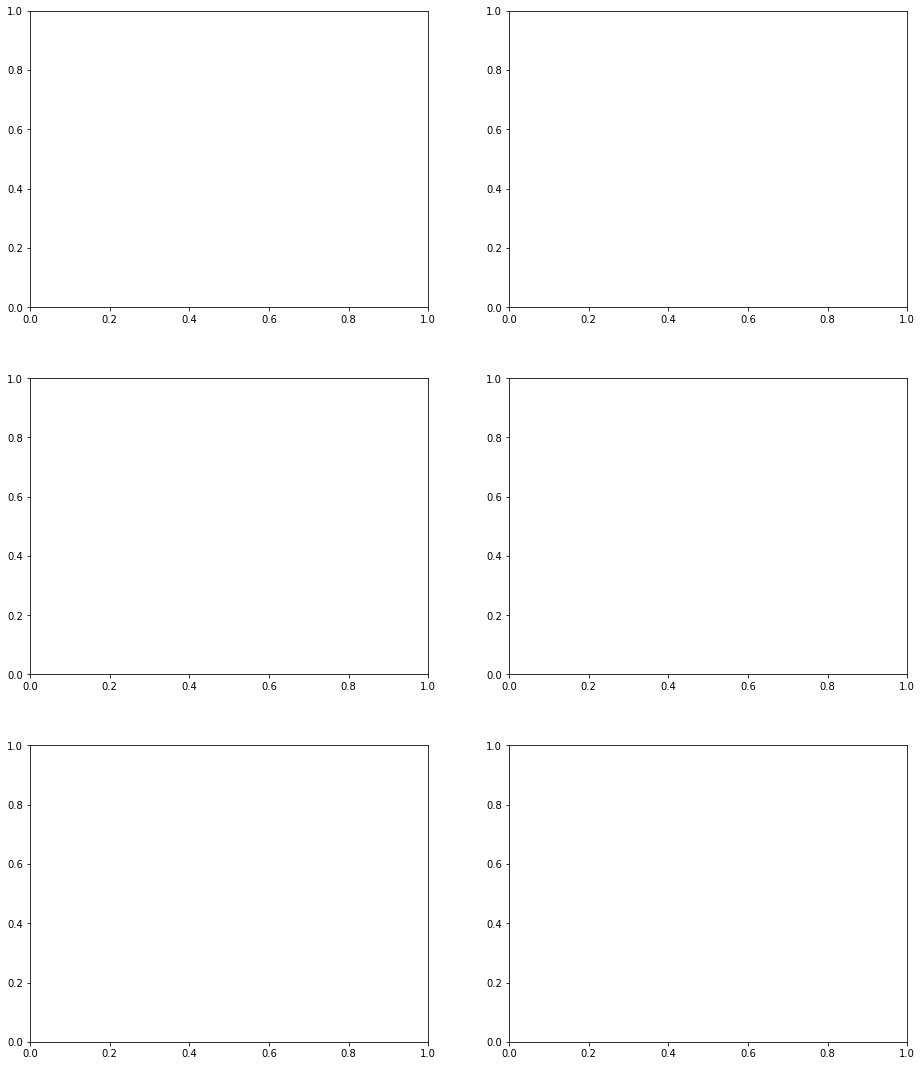

In [195]:
fig, ((ax11, ax12), (ax21, ax22), (ax31, ax32)) = plt.subplots(3, 2, figsize=(14, 16), sharex=False)
fig.tight_layout(pad=5.0)
light_jet = cm.jet#cmap_map(lambda x: x/3 + 0.66, cm.jet)
subfig_index = ['a', 'b', 'c', 'd', 'e', 'f']
ax_list = [ax11, ax12, ax21, ax22, ax31, ax32]
title_size = 18
label_size = 15
tick_size = 13
xy_list = [(cld_list, del_XCO2), (o1_s, del_XCO2), (o2_s, del_XCO2), (o3_s, del_XCO2)]
c_list = [h5_xco2_L2_file, cld_list, cld_list, cld_list]
x_label = ['Cloud distance (km)', '1km-average slope (o2a)',
           '1km-average slope (wco2)', '1km-average slope (sco2)']
y_label = ['$\Delta$XCO2 (ppm)']*4
cbar_label = ['XCO2 L2 file (ppm)'] + ['Cloud distance (km)']*3

qf0 = np.array(qf_list)==0
qf1 = np.array(qf_list)==1
OCO_class_list = [o1, o2]
#ax11.scatter(cld_array[:, :, 0][qf0], o1.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='1 km points (qf=0)')
#ax21.scatter(cld_array[:, :, 0][qf0], o2.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='s25 points (qf=0)')
susan_col = ['o2a_slope', 'wco2_sope']
color_list= ['tab:blue', 'tab:red']
#
for i in range(4):
    ax = ax_list[i]
    x, y = np.array(xy_list[i][0]), np.array(xy_list[i][1])
    mask = ~np.isnan(x) & ~np.isnan(y)
    
    sca = ax.scatter(x[qf1], y[qf1], s=50, marker='^', c=np.array(c_list[i])[qf1], alpha=1, label='qf=1', cmap='autumn_r', edgecolor='grey')
    ax.scatter(x[qf0], y[qf0], s=50, marker='o', c=np.array(c_list[i])[qf0], alpha=1, label='qf=0', cmap='autumn_r', edgecolor='grey')
    
    ax.set_ylabel(y_label[i], fontsize=label_size)
    ax.set_xlabel(x_label[i], fontsize=label_size)
    #ax.set_xticks(range(0, 160, 20))
    ax.xaxis.set_tick_params(labelsize=tick_size)
    ax.yaxis.set_tick_params(labelsize=tick_size)

    #ymin, ymax = -0.75, 0.75
    #xmin, xmax = -0.75, 0.75
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    #ax.plot([xmin, xmax],[0,0],'k--')
    #ax.plot([0, 0],[ymin, ymax],'k--')
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    #ax.text((xmin+(xmax-xmin)*0.45), (ymin+(ymax-ymin)*0.1),
    #        f'y = {a:.2f} x exp(-{b:.2f}x)', fontsize=14)
    #ax.plot([-1, 1, 1, -1, -1], [-1, -1, 1, 1, -1], 'k-')
    #ax.text((xmin+(xmax-xmin)*0.05), (ymin+(ymax-ymin)*0.9),
    #        '({})'.format(subfig_index[i]), fontsize=18, fontweight='bold')
    ax.legend(fontsize=15)
    cbar = fig.colorbar(sca, ax=ax)#, location='bottom')
    cbar.set_label(cbar_label[i], fontsize=15)
#ax11.set_ylabel('O2A slope', fontsize=label_size)
#ax21.set_ylabel('WCO2 slope', fontsize=label_size)
#ax11.set_title('O2A slope', fontsize=title_size)
#ax21.set_title('WCO2 slope', fontsize=title_size)
#fig.suptitle('qf=0', y=1.01, fontsize=title_size+2)
plt.show()

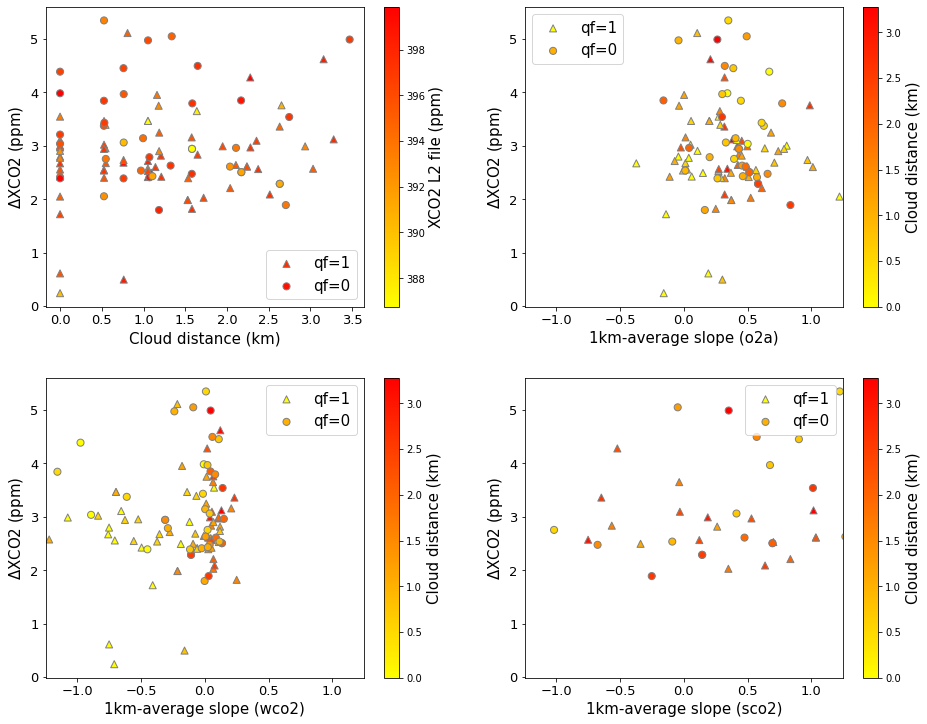

In [230]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(14, 11), sharex=False)
fig.tight_layout(pad=5.0)
light_jet = cm.jet#cmap_map(lambda x: x/3 + 0.66, cm.jet)
subfig_index = ['a', 'b', 'c', 'd', 'e', 'f']
ax_list = [ax11, ax12, ax21, ax22]
title_size = 18
label_size = 15
tick_size = 13
xy_list = [(cld_list, del_XCO2), (o1_s, del_XCO2), (o2_s, del_XCO2), (o3_s, del_XCO2)]
c_list = [h5_xco2_L2_file, cld_list, cld_list, cld_list]
x_label = ['Cloud distance (km)', '1km-average slope (o2a)',
           '1km-average slope (wco2)', '1km-average slope (sco2)']
y_label = ['$\Delta$XCO2 (ppm)']*4
cbar_label = ['XCO2 L2 file (ppm)'] + ['Cloud distance (km)']*3

qf0 = np.array(qf_list)==0
qf1 = np.array(qf_list)==1
OCO_class_list = [o1, o2]
#ax11.scatter(cld_array[:, :, 0][qf0], o1.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='1 km points (qf=0)')
#ax21.scatter(cld_array[:, :, 0][qf0], o2.slope_1km[:, :, 0][qf0], s=25, marker='o', alpha=0.5, label='s25 points (qf=0)')
susan_col = ['o2a_slope', 'wco2_sope']
color_list= ['tab:blue', 'tab:red']
#
for i in range(4):
    ax = ax_list[i]
    x, y = np.array(xy_list[i][0]), np.array(xy_list[i][1])
    mask = ~np.isnan(x) & ~np.isnan(y)
    
    sca = ax.scatter(x[qf1], y[qf1], s=50, marker='^', c=np.array(c_list[i])[qf1], alpha=1, label='qf=1', cmap='autumn_r', edgecolor='grey')
    ax.scatter(x[qf0], y[qf0], s=50, marker='o', c=np.array(c_list[i])[qf0], alpha=1, label='qf=0', cmap='autumn_r', edgecolor='grey')
    
    ax.set_ylabel(y_label[i], fontsize=label_size)
    ax.set_xlabel(x_label[i], fontsize=label_size)
    #ax.set_xticks(range(0, 160, 20))
    ax.xaxis.set_tick_params(labelsize=tick_size)
    ax.yaxis.set_tick_params(labelsize=tick_size)

    #ymin, ymax = -1.25, 1.25
    if i != 0:
        xmin, xmax = -1.25, 1.25
    else:
        xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    #
    #ax.plot([xmin, xmax],[0,0],'k--')
    #ax.plot([0, 0],[ymin, ymax],'k--')
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    #ax.text((xmin+(xmax-xmin)*0.45), (ymin+(ymax-ymin)*0.1),
    #        f'y = {a:.2f} x exp(-{b:.2f}x)', fontsize=14)
    #ax.plot([-1, 1, 1, -1, -1], [-1, -1, 1, 1, -1], 'k-')
    #ax.text((xmin+(xmax-xmin)*0.05), (ymin+(ymax-ymin)*0.9),
    #        '({})'.format(subfig_index[i]), fontsize=18, fontweight='bold')
    ax.legend(fontsize=15)
    cbar = fig.colorbar(sca, ax=ax)#, location='bottom')
    cbar.set_label(cbar_label[i], fontsize=15)
#ax11.set_ylabel('O2A slope', fontsize=label_size)
#ax21.set_ylabel('WCO2 slope', fontsize=label_size)
#ax11.set_title('O2A slope', fontsize=title_size)
#ax21.set_title('WCO2 slope', fontsize=title_size)
#fig.suptitle('qf=0', y=1.01, fontsize=title_size+2)
plt.show()

In [225]:
qf_lon.flatten()[qf_array[:, :, 0].flatten()==1].size

87

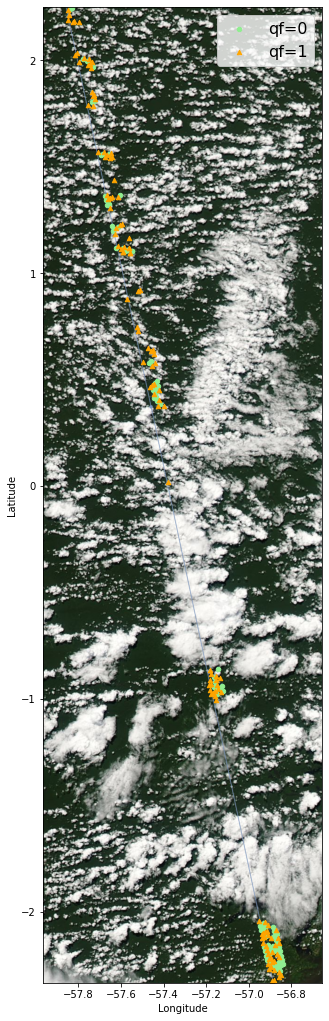

In [260]:
f,frame=plt.subplots(figsize=(5, 20))
img = png[0]
wesn= png[1]
img = mpimg.imread(img)
frame.imshow(img,extent=wesn)
lon_dom = o1.dom[:, :2]
lat_dom = o1.dom[:, 2:]
frame.set_xlim(np.min(lon_dom), np.max(lon_dom))
frame.set_ylim(np.min(lat_dom), np.max(lat_dom))
frame.scatter(qf_lon.flatten()[qf_array[:, :, 0].flatten()==0], qf_lat.flatten()[qf_array[:, :, 0].flatten()==0], s=20,
              marker='o', color='lightgreen', label='qf=0')
frame.scatter(qf_lon.flatten()[qf_array[:, :, 0].flatten()==1], qf_lat.flatten()[qf_array[:, :, 0].flatten()==1], s=20,
              marker='^', color='orange', label='qf=1')

#for i in range(len(boundary_list)):
#    boundary = boundary_list[i]
#    plot_rec(np.mean(boundary[0][:2]), np.mean(boundary[0][2:]), 
#             0.5, lat_interval, 
#             frame, 'r')
plt.legend(fontsize=16, facecolor='white')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

In [270]:
lon_list

[-57.73304,
 -57.720448,
 -57.72889,
 -57.737328,
 -57.745842,
 -57.754402,
 -57.72474,
 -57.73318,
 -57.737473,
 -57.734013,
 -57.742268,
 -57.738403,
 -57.746655,
 -57.755005,
 -57.75098,
 -57.759323,
 -57.772038,
 -57.78045,
 -57.79747,
 -57.8061,
 -57.81468,
 -57.798115,
 -57.819164,
 -57.827625,
 -57.848946,
 -57.844635,
 -57.83193,
 -57.840378,
 -57.848877,
 -57.58448,
 -57.593006,
 -57.601604,
 -57.563393,
 -57.61447,
 -57.623158,
 -57.627186,
 -57.597195,
 -57.605717,
 -57.614227,
 -57.622814,
 -57.631447,
 -57.64013,
 -57.644394,
 -57.652863,
 -57.60618,
 -57.614506,
 -57.657124,
 -57.665787,
 -57.644196,
 -57.65277,
 -57.661385,
 -57.67005,
 -57.66567,
 -57.67433,
 -57.631657,
 -57.64449,
 -57.65279,
 -57.648754,
 -57.65705,
 -57.66545,
 -57.673927,
 -57.678123,
 -57.686584,
 -57.69512,
 -57.707886,
 -57.43866,
 -57.45562,
 -57.45994,
 -57.468548,
 -57.447247,
 -57.498734,
 -57.451477,
 -57.459892,
 -57.472633,
 -57.51984,
 -57.52408,
 -57.51173,
 -57.52012,
 -57.57175,
 -57.

No handles with labels found to put in legend.


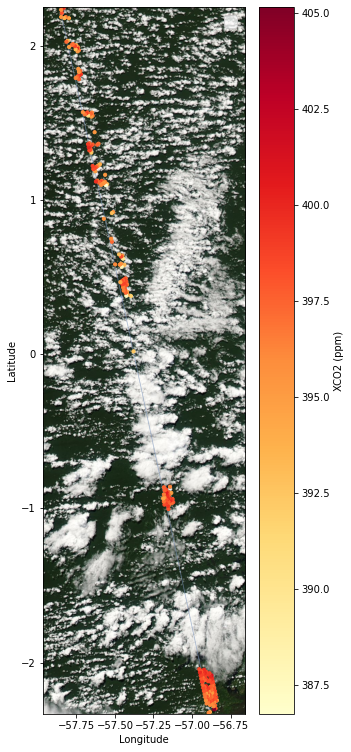

In [275]:
f,frame=plt.subplots(figsize=(5, 13))
img = png[0]
wesn= png[1]
img = mpimg.imread(img)
frame.imshow(img,extent=wesn)
lon_dom = o1.dom[:, :2]
lat_dom = o1.dom[:, 2:]
frame.set_xlim(np.min(lon_dom), np.max(lon_dom))
frame.set_ylim(np.min(lat_dom), np.max(lat_dom))
cc=frame.scatter(lon_list, lat_list, s=10,
              marker='o', c=np.array(xco2)*1e6, cmap='YlOrRd')

cbar=f.colorbar(cc)
cbar.set_label('XCO2 (ppm)')
#for i in range(len(boundary_list)):
#    boundary = boundary_list[i]
#    plot_rec(np.mean(boundary[0][:2]), np.mean(boundary[0][2:]), 
#             0.5, lat_interval, 
#             frame, 'r')
plt.legend(fontsize=16, facecolor='white')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

In [431]:
output = pd.DataFrame(np.array([h5_snd, h5_lat, h5_lon, h5_xco2_retrieved_unpert]).T, 
                      columns=['SoundingID', 'latitude', 'longitude', 'unperturbed_retrieved_CO2'])
output.SoundingID = output.astype({'SoundingID': 'str'})
output.SoundingID = output.SoundingID.apply(lambda x: x[:-2])

output.SoundingID.size

217

In [432]:
output.sort_values(by=['SoundingID'], inplace=True)

In [314]:
output.to_csv('unperturb_CO2_retrieval.csv', index=False, na_rep='NaN',
              encoding='ascii')#float_format=str, quotechar='"')

In [433]:
output.sort_values(by=['SoundingID']).to_csv('unperturb_CO2_retrieval_update.txt',
                                             sep=' ', index=False, na_rep='NaN',
                                             encoding='ascii')#float_format=str, quotechar='"')

In [441]:
import h5py
import numpy as np


h = h5py.File('unperturb_CO2_retrieval_update.h5', 'w')
s = h.create_group('SoundingID')
s.create_dataset('data', data=output.SoundingID, dtype=int)
s.create_dataset('unit', data='')
lat = h.create_group('latitude')
lat.create_dataset('data', data=output.latitude, dtype=float)
lat.create_dataset('unit', data='degree')
lon = h.create_group('longitude')
lon.create_dataset('longitude', data=output.longitude, dtype=float)
lon.create_dataset('unit', data='degree')
co2 = h.create_group('unperturbed_retrieved_CO2')
co2.create_dataset('data', data=output.unperturbed_retrieved_CO2, dtype=float)
co2.create_dataset('unit', data='ppmv')


AttributeError: 'Series' object has no attribute 'encode'

In [435]:
h.close()

In [437]:
h2 = h5py.File('unperturb_CO2_retrieval_update.h5')
h2['SoundingID']['data'][...]
#print(h2['unperturbed_retrieved_CO2'][...])
h2.close()

In [214]:
output.SoundingID[:10]

0    2.015062e+15
1    2.015062e+15
2    2.015062e+15
3    2.015062e+15
4    2.015062e+15
5    2.015062e+15
6    2.015062e+15
7    2.015062e+15
8    2.015062e+15
9    2.015062e+15
Name: SoundingID, dtype: float64